In [1]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import graspy

from sklearn.metrics import pairwise_distances
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm_notebook as tqdm

sns.set()

In [2]:
def generate_latent_positions(n=50, d=2, acorn=None):
    """
    A function to generate an adjacency matrix.
    
    Input
    n - int
        If P is None then n is the number of latent positions to randomly generate.
    d - int
        If P is None the d is the dimension of the latent positions.
    acorn - int
        Random seed.
        
    Return
    X - np.array (shape=(n,d))
        An array of uniformly distributed points in the positive unit sphere
    """
    
    if acorn is not None:
        np.random.seed(acorn)
        
    mvns = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)

    mvns = abs(mvns) / np.linalg.norm(mvns, axis=1)[:, None]

    unis = np.random.uniform(size=n)**(1/d)
    X = mvns * unis[:, None]
                
    return X


def sample_moment(X, k=1):
    """
    Estimate the kth sample moment.
    
    Input
    X - np.array (length=n or shape=(n,d))
        i.i.d. realizations of a random variable.
    k - int (default=1)
        Moment to estimate.
    """
    if X.ndim == 1:
        estimate = np.mean(X**k)
    elif X.ndim == 2:
        n, d = X.shape
        if k == 1:
            estimate = np.mean(X, axis=0)
        elif k == 2:
            estimate = np.mean(np.array([X[i, np.newaxis].T @ X[i, np.newaxis] for i in range(n)]), axis=0)
            
    return estimate
        
    
def ASE_covariance(X, ind):
    x = X[ind]

    # this might break with ind = 0
    X_no_x = np.concatenate((X[:ind], X[ind+1:]))
    
    n, d = X_no_x.shape
    
    covs = np.array([X_no_x[i, np.newaxis].T @ X_no_x[i, np.newaxis] for i in range(n)])
    innards = np.array([x @ X_no_x[i] - x @ covs[i] @ x[:, np.newaxis] for i in range(n)])
    
    delta = np.mean(covs, axis=0)
    delta_inv = np.linalg.pinv(delta)
    
    scaled_covs = np.mean(np.array([covs[i] * innards[i] for i in range(n)]), axis=0)
        
    Sigma_x = delta_inv @ scaled_covs @ delta_inv
    
    return Sigma_x


def LSE_covariance(X, ind):
    x = X[ind]
    
    X_no_x = np.concatenate((X[:ind], X[ind+1:]))
    n, d = X_no_x.shape
    mu = np.mean(X_no_x, axis=0)
    
    denoms = np.array([X_no_x[i] @ mu for i in range(n)])
    
    # could do more succintly
    mu_t = np.mean(np.array([X_no_x[i] / denoms[i] for i in range(n)]), axis=0)
    
    
    covs = np.array([X_no_x[i, np.newaxis].T @ X_no_x[i, np.newaxis] for i in range(n)])
    delta_t = np.mean(np.array([covs[i] / denoms[i] for i in range(n)]), axis=0)
    
    delta_t_inv = np.linalg.pinv(delta_t)
    
    prod11 = np.array([(delta_t_inv @ X_no_x[i, np.newaxis].T) / denoms[i] for i in range(n)])
    prod12 = x[:, np.newaxis].T / (2*x@mu)
    prod = prod11 - prod12.T
    
    prod21 = np.array([(X_no_x[i, np.newaxis] @ delta_t_inv) / denoms[i] for i in range(n)])
    prod22 = x / (2*x@mu)
    prod2 = prod21 - prod22
    prod = prod @ prod2
    
#     print((x @ X_no_x[0]).shape)
#     print(x[:, np.newaxis].shape, covs[0].shape)
    prod3 = np.array([x @ X_no_x[i] - x[:, np.newaxis].T @ covs[i] @ x[:, np.newaxis] for i in range(n)])[0]
#     print(prod3)
    prod3 = prod3 / (x@mu)
    
    prod = prod * prod3[:, np.newaxis]
    
    Sigma_x = np.mean(np.array(prod), axis=0)
        
    return Sigma_x


def identity(X, ind):
    _, d = X.shape
    return np.eye(d)

def laplacian_means(X, T=None):
    n,d = X.shape
    
    if T is None:
        T = np.sqrt(np.diag(1/(X @ X.T @ np.ones(n))))
    
    return T @ X
  

def generate_distance_matrix(A, embedding_functions, covariance_functions, ind=0,acorn=None):
    """
    A function to generate a distance matrix given an adjacency matrix. The ith column of the
    distance matrix is the Euclidean distance from the first node in the graph to the other
    nodes in the ith embedding.
    
    Input
    A - np.array (shape=(n,n))
        Probability matrix or adjacency matrix.
    emebedding_functions - list of functions (length=J)
        Embedding methods for A.
    covariance_functions - list of np.arrays (length=J)
        Functions estimate the covariance used to calculate distances.
    ind - int
        Index of v star.
    acorn - int
        Random seed.
        
    Return
    dist_matrix - np.array (shape=(n, J))
        Distance matrix where the ith column is the Euclidean distance from v_star
        to all of the other nodes in the graph in the ith embedding.
    """
    
    if acorn is not None:
        np.random.seed(acorn)
        
    n = A.shape[0]
        
    J = len(covariance_functions)
            
    dist_matrix = np.zeros((n, J))
    
    for j, embed in enumerate(embedding_functions):
        if j == 0:
            temp_X = embed(A)
        else:
            temp_X = np.sqrt(n) * embed(A)
            
        if isinstance(covariance_functions[j], np.ndarray):
            temp_cov = covariance_functions[j]
        else:
            temp_cov = covariance_functions[j](temp_X, ind)
            
        diffs = np.array([temp_X[ind] - temp_X[i] for i in range(n)])
        dist_matrix[:, j] = np.sqrt(np.array([diffs[i].T @ temp_cov @ diffs[i] for i in range(n)]))
       
        if np.sum(dist_matrix[:, j] < 0) > 0:
            print("i broke on distance %i"%(j))
    return dist_matrix


def generate_S_indices(dist_matrix, alpha, n_inds=1, return_new_dists=False, beta=0.5):
    """
    A function to generate the nodes of interest.
    
    Input
    dist_matrix - np.array (shape=(n,J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    alpha - float or array-like
        Coefficients of the distances to generate the ground truth. alpha can only be an int
        if J == 2. If alpha is array-like then the sum of alpha must be 1.
    n_inds - int or func
        Number of vertices in the vertex set of interest. If n_inds is a function then the
        ceiling of n_inds(n) is used.
        
    Return
    S - np.array (length=n_inds)
        A list of indices of length n_inds in range(1,n) corresponding to vertices of interest.
    """
    
    n, J = dist_matrix.shape
    
    if isinstance(alpha, float) or alpha == 0 or alpha == 1:
        if J == 2:
            alpha = [alpha, 1-alpha]
        elif J == 4:
            alpha = np.array([beta*alpha, beta*(1-alpha), (1-beta)*alpha, (1-beta)*(1-alpha)])
    
    if not np.isclose(np.sum(alpha), 1):
        print(np.sum(alpha))
        assert np.sum(alpha) == 1
    
    if not isinstance(n_inds, int):
        n_inds = int(np.math.ceil(n_inds(n)))
    
    new_distances = np.average(dist_matrix, axis=1, weights=alpha)
    
    new_nearest_neighbors = np.argsort(new_distances)
    
    S = new_nearest_neighbors[1:n_inds+1]
    
    if return_new_dists:
        return S, new_distances
    else:
        return S


def optimal_distance(dist_matrix, S_indices, model_name=None, return_new_dists=True):
    """
    A function to find the weights of optimal linear combination of distances.
    
    Input
    dist_matrix - np.array (shape=(n, J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    S_indices - array-like
        Array-like containing the indices of the vertices that should be at the top of the
        nomination list for the vertex of interest.
        
    Return
    weights - np.array (length=J)
        Array containing the coefficients for the optimal distance function.
    """
    
    n, J = dist_matrix.shape
    M = np.sum(abs(dist_matrix))
    
    S = len(S_indices)
    Q_indices = np.array([i for i in range(1, n) if i not in S_indices])
    Q = len(Q_indices)
    
    M = np.sum(abs(dist_matrix))
    
    if model_name is not None:
        m = gp.Model(name='%s'%(model_name))
    else:
        m= gp.Model()
        
    m.setParam('OutputFlag', 0)

    ind = m.addVars(Q, vtype=GRB.BINARY, name='ind')
    m.setObjective(gp.quicksum(ind), GRB.MINIMIZE)

    w = m.addVars(J, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='w')
    m.addConstr(w.sum() == 1)

    # There's likely a more pythonic way to set up these constraints (in particular using m.addConstrs(..))
    for s in S_indices:
        temp_s = gp.tupledict([((i), dist_matrix[s, i]) for i in range(J)])
        for i, q in enumerate(Q_indices):
            temp_q = gp.tupledict([((i), dist_matrix[q, i]) for i in range(J)])
            m.addConstr(w.prod(temp_s) <= w.prod(temp_q) + ind[i]*M)
        
    m.optimize()
    
    alpha_hat = np.array([i.X for i in list(w.values())])
    
    if model_name:
        m.write('%s.ip'%(model_name))
        
    if return_new_dists:
        return alpha_hat, np.average(dist_matrix, axis=1, weights=alpha_hat)
    
    return alpha_hat


def rank_distance(true_ranks, estimated_ranks):
    return np.mean(abs(true_ranks - estimated_ranks))


def mean_reciprocal_rank(rank_list, inds):
    """
    Calculates mean reciprocal rank given a rank list and set of indices of interest.
    
    Input
    rank_list - array-like (length=n-1)
        A ranked array-like of objects (assumed to be integers).
    inds - array-like (length<=n-1)
        A array-like of objects (assumed to be integers).
        
    Return
    mrr - float
        Mean reciprocal rank of the objects in inds.
    """
        
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
    return np.mean(1/ranks)

def mean_rank(rank_list, inds):
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
#     print(ranks)
    return np.mean(ranks)


def remove_S_indices(rank_lists, S_indices):
    new_rank_lists = []
    for i, r in enumerate(rank_lists):
        idx = np.array([np.where(r == s)[0][0] for s in S_indices])
        new_rank_lists.append(np.delete(r, idx))
        
    return new_rank_lists


def average_rank(rank_lists, s_star_indices):
    
    average_ranks = np.zeros(len(rank_lists))
    
    for i, r in enumerate(rank_lists):
        average_ranks[i] = np.mean(np.array([np.where(r == s)[0][0] for s in s_star_indices]))
    
    return average_ranks

def monte_carlo(mc_its, P, emebdding_functions, covariance_functions, 
                alpha, n_inds, s_stars, latent=True, poc=False, 
                metric='rank', beta=0.25, 
                acorn=None):
    """
    Function to run a bunch of simulations.
    
    See documentation for above functions.
    
    Return
    mmrs - np.array (shape=(mc_its, J+1))
        Matrix of mean reciprocal ranks for each of the embedding functions and the estimated
        optimal distance.
    """
    if acorn is None:
        np.random.seed(acorn)
        
    J = len(embedding_functions)
    
    if J == 2:
        c = 1
    elif J == 4:
        c = 3
    else:
        c=1
        
    errors = np.zeros((mc_its, 3))
    
    if J in [2, 4]:
        alpha_hats = np.zeros(mc_its)

    true_dist = generate_distance_matrix(P, embedding_functions=embedding_functions, 
                                         covariance_functions=covariance_functions)
    
    all_S_inds, new_dists = generate_S_indices(true_dist, 0, n_inds=n_inds, return_new_dists=True, beta=beta)
    print("lse", all_S_inds)
    
    all_S_inds, new_dists = generate_S_indices(true_dist, 1, n_inds=n_inds, return_new_dists=True, beta=beta)
    print("ase", all_S_inds)
    
    all_S_inds, new_dists = generate_S_indices(true_dist, alpha, n_inds=n_inds, return_new_dists=True, beta=beta)
    print("alpha", all_S_inds)
    
    
    
    true_rankings = np.argsort(new_dists)
        
    if isinstance(s_stars, np.ndarray):
        for i,s in enumerate(s_stars):
            if s < 0:
                s_stars[i] = len(all_S_inds) + s
        S_star_inds = all_S_inds[s_stars]
    elif isinstance(s_stars, int):
        S_star_inds = np.random.choice(all_S_inds, size=s_stars)
    else:
        raise ValueError('bad')
    S_inds = np.array([i for i in all_S_inds if i not in S_star_inds])
        
    for i in range(mc_its):
        connected = False
        while not connected:
            A = graspy.simulations.rdpg(X)
            connected = graspy.utils.is_fully_connected(A)
            
        if poc:
            if J == 2:
                dist_matrix = true_dist
            elif J == 4:
                dist_matrix = generate_distance_matrix(P, embedding_functions[2:], 
                                                   covariance_functions=covariance_functions[2:])
        else:
            if J == 2:
                dist_matrix = generate_distance_matrix(A, embedding_functions, 
                                                   covariance_functions=covariance_functions)
                
            elif J == 4:
                dist_matrix = generate_distance_matrix(A, embedding_functions[2:], 
                                                   covariance_functions=covariance_functions[2:])
        
#         if not latent:
#             all_S_inds = generate_S_indices(true_dist, alpha, n_inds=n_inds, beta=beta)
#             if s_stars == 1:
#                 S_star_inds = np.array([len(all_S_inds) - 1])
#             else:
#                 S_star_inds = np.random.choice(all_S_inds, size=s_stars)
#             S_inds = np.array([i for i in all_S_inds if i not in S_star_inds])
            
        alpha_hat_vec, opt_dists = optimal_distance(dist_matrix, S_inds)
        
        if J in [2, 4]:
            alpha_hats[i] = alpha_hat_vec[0]
            
#         print(dist_matrix)
        if J == 2:
            ranked_lists = [np.argsort(dist_matrix[:, j]) for j in range(J)]
        elif J == 4:
            ranked_lists = [np.argsort(dist_matrix[:, j]) for j in range(J-2)]
        ranked_lists.append(np.argsort(opt_dists))
        
        if J == 4:
#             alpha_hat_vec_ASE, opt_dists_ASE = optimal_distance(dist_matrix[:, np.array([0,2])], S_inds)
#             alpha_hat_vec_LSE, opt_dists_LSE = optimal_distance(dist_matrix[:, np.array([1,3])], S_inds)
#             ranked_lists.append(np.argsort(opt_dists_ASE))
#             ranked_lists.append(np.argsort(opt_dists_LSE))
            pass
        

#         print("\n")
#         for R in ranked_lists:
#             print(R)
        if metric == 'error':
            errors[i] = np.array([rank_distance(S_star_inds, np.where(R == true_rankings[S_star_inds])) for R in ranked_lists])
        elif metric == 'rank':
            ranked_lists = remove_S_indices(ranked_lists, S_inds)
#             print(ranked_lists)
            errors[i] = average_rank(ranked_lists, S_star_inds)
        
    if J in [2, 4]:
        return alpha_hats, errors
    else:
        return errors
    
def generate_new_points(n, x, v_star, c=0, epsilon=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    dist = np.linalg.norm(x - v_star)**2
    
    d = len(x)
    
    if r == 0:
        return np.ones((n, d)) * x
        
    mvns = np.random.multivariate_normal(x, c**2 * np.eye(d), size=10*n)

    mvns = mvns / np.linalg.norm(mvns, axis=1)[:, None]

    unis = np.random.uniform(size=10*n)**(1/d)
    X = mvns * unis[:, None]
    
    farther_than_x = np.linalg.norm(X - v_star, axis=1)**2 >= dist + epsilon
    
    return X[farther_than_x][:n]


def identifiability_check(dist_matrix, alphas):
    
    n, J = dist_matrix.shape
    assert J == 2
    
    rank_lists = []
    
    for i, a in enumerate(alphas):
        new_dist = a*dist_matrix[:, 0] + (1-a)*dist_matrix[:, 1]
        rank_lists.append(list(np.argsort(new_dist)[1:]))
        
    unique_lists = []
    unique_ids = np.zeros(len(alphas))
    
    for i, a in enumerate(alphas):
        temp_list = rank_lists[i]
        unique = True
        for j, list_ in enumerate(unique_lists):
            if list_ == temp_list:
                unique_ids[i] = j+1
                unique = False
        if unique:
            unique_lists.append(temp_list)
            unique_ids[i] = len(unique_lists)
    return unique_ids

def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def plot_kde_differences(all_data, figsize=(8,6), h=1, num=1000, suptitle=None, filename=None):
    J, n = all_data.shape
    colors = sns.color_palette('Set1', n_colors=J)
    
    min_ = min(np.array([min(data) for data in all_data]))
    max_ = max(np.array([max(data) for data in all_data]))
    
    linspace = np.linspace(min_ - h, max_ + h, num)
    
    fig, ax = plt.subplots(J, J, sharex=True, sharey=True)
        
    for i, di in enumerate(all_data):
        for j, dj in enumerate(all_data):
            if i == j:
                temp_kdei = gaussian_kde(di)
                ax[i,i].plot(linspace, temp_kdei.pdf(linspace), c=colors[-i-1])
            else:
                temp_kdei = gaussian_kde(di)
                temp_kdej = gaussian_kde(dj)
                
                ax[i,j].plot(linspace, temp_kdei.pdf(linspace) - temp_kdej.pdf(linspace), ls="--")
            ax[i,j].axhline(y=0, c='k', lw=1)
    if suptitle is not None:
        fig.suptitle(suptitle)
        
    if filename:
        plt.savefig(filename)
        

def find_max_alpha(dist_matrix, S_indices, min_alpha, tol=0.0001):
    n, J = dist_matrix.shape
    
    assert J == 2
    
    min_alpha_dist = np.average(dist_matrix, axis=1, weights = (1 - min_alpha, min_alpha))
    min_alpha_ranks = np.argsort(min_alpha_dist)
    
    obj_func_value = max([np.where(min_alpha_ranks == s)[0][0] for s in S_indices])
    
    interval = np.linspace(min_alpha, 1, num=(1 - min_alpha) / 0.0001)
    
    found = False
    current = (1 + min_alpha)/2
    while not found:
        temp_alpha = interval[np.argmin(abs(interval - current))]
        temp_dist = np.average(dist_matrix, axis=1, weights = (1 - temp_alpha, temp_alpha))
        
        temp_obj_func_value = max([np.where(min_alpha_ranks == s)[0][0] for s in S_indices])
        

    
    
    
    
    
        
    

In [43]:
def find_desireable_P(n, d, alpha_star, embedding_fns, covariance_fns, acorn, threshold=0.005):
    np.random.seed(acorn)
    
    X = generate_latent_positions(n, d)
    X0 = np.array([0.5, 0.5])[np.newaxis, :]
    X = np.concatenate((X0, X), axis=0)
    
    P = X @ X.T
    
    X_hat = graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform(P)
    ase_dist = pairwise_distances(X_hat, X_hat)

    X_bre = graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform(P)
    lse_dist = pairwise_distances(X_bre, X_bre)

    alpha_star_dist = (1-alpha_star) * lse_dist + alpha_star*ase_dist
    alpha_star_dist = (alpha_star_dist + alpha_star_dist.T)/2

    alpha_star_embed = graspy.embed.ClassicalMDS(n_components=2, dissimilarity='precomputed').fit_transform(alpha_star_dist)

    dist_matrix = np.vstack((ase_dist[0,:],lse_dist[0,:])).T
    S_indices = generate_S_indices(dist_matrix, alpha_star, n_inds=7)

    n_inds = 5+1

    X_hat = graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform(P)
    ase_dist = pairwise_distances(X_hat, X_hat)

    X_bre = np.sqrt(n) * graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform(P)
    lse_dist = pairwise_distances(X_bre, X_bre)

    alpha_star_dist = (1-alpha_star) * lse_dist + alpha_star*ase_dist
    alpha_star_dist = (alpha_star_dist + alpha_star_dist.T)/2

    alpha_star_embed = graspy.embed.ClassicalMDS(n_components=2, dissimilarity='precomputed').fit_transform(alpha_star_dist)
    alpha_star_embed = alpha_star_embed @ generate_2d_rotation(theta=np.pi/2)

    dist_matrix = np.vstack((ase_dist[0,:],lse_dist[0,:])).T

    S_indices = generate_S_indices(dist_matrix, alpha_star, n_inds=n_inds)
    S_indices_ASE = generate_S_indices(dist_matrix, 1.0, n_inds=n_inds)
    S_indices_LSE = generate_S_indices(dist_matrix, 0.0, n_inds=n_inds)
    
    s_star = S_indices[-1]
    ase = [ind for ind in S_indices_ASE if ind not in S_indices[:-1]][0]
    lse = [ind for ind in S_indices_LSE if ind not in S_indices[:-1]][0]
    
    embeddings = [X_bre, alpha_star_embed, X_hat]
    points = [lse, S_indices[-1], ase]
    
    min_dist=2
    print(s_star, lse, ase)
    if s_star != ase and s_star != lse:
        for i, emb in enumerate(embeddings):
            dists = []
            temp_dist = np.linalg.norm(emb[0] - emb[points[i]])
            for j in range(3):
                if i != j:
                    temp2_dist = np.linalg.norm(emb[0] - emb[points[j]])
                    dists.append(abs(temp_dist - temp2_dist))
        
            if min(dists) < min_dist:
                min_dist = min(dists)
#             if abs(temp_dist1-temp_dist2) > threshold:
#                 if abs(temp_dist1-temp_dist3) > threshold:
#                     if abs(temp_dist2-temp_dist3) > threshold:
#                         check.append(True)
#             else:
#                 check.append(False)
        return min_dist
    else:
        return min_dist

In [44]:
find_desireable_P(n, d, alpha_star, embedding_functions, covariance_functions, 18008)

42 42 10


2

In [84]:
n, d = 50, 2
alpha_star=0.5
embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [identity, identity]

for acorn in range(19000):
    if acorn % 1000 == 0:
        print(acorn)
    temp = find_desireable_P(n, d, alpha_star, embedding_functions, covariance_functions, acorn)
    
    if temp != 0:
        print(acorn, temp)

0
8 22 8
0 2
34 50 34
1 2
36 36 36
2 2
10 10 13
3 2
4 4 47
4 2
42 49 1
5 0.0006357946344466847
37 37 24
6 2
50 50 50
7 2
6 5 6
8 2
30 31 45
9 0.0037315015622755854
27 27 27
10 2
7 7 25
11 2
19 14 19
12 2
40 45 40
13 2
17 14 17
14 2
47 47 5
15 2
6 17 6
16 2
18 18 18
17 2
29 2 15
18 0.000497909735587887
46 46 28
19 2
25 25 37
20 2
43 2 43
21 2
8 8 9
22 2
3 22 3
23 2
49 49 26
24 2
18 18 18
25 2
22 31 22
26 2
42 50 42
27 2
33 21 33
28 2
3 22 3
29 2
20 20 20
30 2
20 20 20
31 2
4 4 15
32 2
16 18 26
33 0.000627979387521127
44 44 44
34 2
4 4 4
35 2
3 3 3
36 2
14 5 14
37 2
45 30 5
38 0.01724228065326175
21 21 41
39 2
9 9 5
40 2
31 31 31
41 2
18 26 18
42 2
27 27 27
43 2
28 46 28
44 2
16 13 16
45 2
26 46 26
46 2
7 7 3
47 2
15 13 17
48 0.0028440197609171103
16 32 16
49 2
20 32 20
50 2
9 9 9
51 2
11 31 11
52 2
4 4 4
53 2
17 4 17
54 2
39 50 39
55 2
17 18 44
56 0.0034941330089165723
20 17 1
57 0.003438340110807736
25 29 25
58 2
45 45 20
59 2
40 40 1
60 2
30 30 30
61 2
13 13 13
62 2
17 50 17
63 2
21 2

25 11 46
490 0.0007982477062261073
7 42 7
491 2
3 7 3
492 2
11 11 37
493 2
17 40 17
494 2
5 22 5
495 2
23 23 31
496 2
35 39 35
497 2
13 11 13
498 2
46 42 46
499 2
21 21 21
500 2
10 10 10
501 2
5 5 19
502 2
44 49 44
503 2
30 30 29
504 2
11 11 11
505 2
3 3 9
506 2
6 30 6
507 2
3 5 3
508 2
28 28 28
509 2
20 20 12
510 2
8 32 8
511 2
28 28 36
512 2
12 12 46
513 2
22 22 29
514 2
35 16 35
515 2
5 5 15
516 2
27 47 27
517 2
13 14 13
518 2
1 11 12
519 0.007838793257977872
30 49 30
520 2
9 9 13
521 2
17 17 11
522 2
44 44 35
523 2
38 1 38
524 2
18 8 50
525 0.004801879582110535
50 13 43
526 0.008760782488574509
26 9 24
527 0.002093939267651751
19 15 19
528 2
9 44 37
529 0.009895129344836523
33 42 33
530 2
13 12 13
531 2
7 7 39
532 2
39 39 31
533 2
20 20 20
534 2
33 33 50
535 2
16 31 16
536 2
3 3 2
537 2
20 26 20
538 2
28 5 28
539 2
21 21 21
540 2
42 42 19
541 2
18 9 18
542 2
38 38 22
543 2
37 37 37
544 2
8 8 38
545 2
11 50 27
546 0.004687141295083297
14 32 14
547 2
21 21 39
548 2
31 34 31
549 2
41 

40 40 15
968 2
12 50 12
969 2
2 2 25
970 2
48 48 48
971 2
38 6 34
972 0.004410170023467469
36 36 18
973 2
46 46 15
974 2
5 18 20
975 0.007930544351095747
50 38 50
976 2
9 9 36
977 2
47 36 47
978 2
8 38 43
979 0.007712220688315091
24 28 7
980 0.006526817718354283
4 4 4
981 2
6 9 5
982 0.005712827070734977
2 2 16
983 2
26 34 26
984 2
38 38 1
985 2
38 38 38
986 2
38 48 38
987 2
7 9 7
988 2
45 2 47
989 0.003231869847052954
16 31 16
990 2
33 19 33
991 2
45 45 11
992 2
29 27 29
993 2
49 49 49
994 2
32 32 5
995 2
37 37 37
996 2
36 50 29
997 0.004291751969656088
23 4 23
998 2
17 34 17
999 2
1000
24 41 21
1000 0.0052825935259559476
30 30 38
1001 2
45 45 26
1002 2
45 45 39
1003 2
17 17 17
1004 2
18 20 18
1005 2
29 29 6
1006 2
22 22 42
1007 2
48 48 48
1008 2
31 29 8
1009 7.938423568962238e-05
11 38 17
1010 0.0022818139620041367
33 33 38
1011 2
10 12 10
1012 2
30 30 49
1013 2
21 38 21
1014 2
2 10 47
1015 0.004572713278142876
15 15 15
1016 2
19 13 19
1017 2
10 10 46
1018 2
11 11 34
1019 2
36 34 30


1410 2
37 35 37
1411 2
11 11 40
1412 2
45 14 23
1413 0.00259107151382737
26 26 11
1414 2
46 46 46
1415 2
49 2 49
1416 2
4 4 43
1417 2
20 20 29
1418 2
8 31 5
1419 0.003476140739663125
3 3 3
1420 2
8 8 42
1421 2
23 30 23
1422 2
37 37 37
1423 2
43 43 35
1424 2
17 33 17
1425 2
9 9 37
1426 2
18 22 9
1427 4.54589668575367e-05
16 29 16
1428 2
18 42 18
1429 2
44 28 44
1430 2
17 4 17
1431 2
49 49 49
1432 2
12 12 44
1433 2
14 2 9
1434 0.00235032864006382
2 2 2
1435 2
43 48 43
1436 2
14 14 42
1437 2
15 15 32
1438 2
32 32 32
1439 2
50 50 50
1440 2
50 50 50
1441 2
14 7 14
1442 2
41 41 2
1443 2
18 18 43
1444 2
18 18 17
1445 2
1 29 1
1446 2
34 42 34
1447 2
4 4 49
1448 2
41 18 41
1449 2
32 32 32
1450 2
35 13 35
1451 2
47 47 6
1452 2
34 34 34
1453 2
3 37 44
1454 0.00920539136258186
17 17 23
1455 2
40 40 17
1456 2
20 20 48
1457 2
34 34 37
1458 2
17 17 17
1459 2
10 10 7
1460 2
35 17 35
1461 2
47 38 47
1462 2
10 10 19
1463 2
39 23 12
1464 0.004637531710069448
18 18 41
1465 2
13 39 13
1466 2
40 27 40
1467 

1864 0.0029837648015391405
27 27 14
1865 2
18 1 18
1866 2
8 17 31
1867 0.0010610218637294444
32 32 32
1868 2
30 30 14
1869 2
20 20 11
1870 2
40 26 40
1871 2
15 15 15
1872 2
17 17 17
1873 2
39 39 39
1874 2
9 9 21
1875 2
12 9 12
1876 2
41 9 41
1877 2
28 28 37
1878 2
31 31 31
1879 2
40 40 40
1880 2
42 15 42
1881 2
19 18 19
1882 2
2 3 2
1883 2
39 23 7
1884 0.003345235203165292
35 35 10
1885 2
34 20 34
1886 2
38 38 22
1887 2
30 21 30
1888 2
21 38 21
1889 2
5 5 34
1890 2
26 26 49
1891 2
43 43 43
1892 2
22 22 15
1893 2
19 9 19
1894 2
46 46 46
1895 2
44 44 44
1896 2
9 9 2
1897 2
37 37 41
1898 2
14 14 14
1899 2
28 28 25
1900 2
45 45 10
1901 2
30 30 30
1902 2
8 5 8
1903 2
40 40 7
1904 2
49 29 48
1905 0.0013915635757304756
22 4 38
1906 0.004369547410134567
32 12 32
1907 2
22 22 5
1908 2
10 10 10
1909 2
28 28 28
1910 2
32 32 32
1911 2
20 20 14
1912 2
37 46 37
1913 2
25 25 40
1914 2
45 7 17
1915 0.004701255307248964
30 30 30
1916 2
30 29 25
1917 0.007903467129056069
10 10 45
1918 2
6 6 6
1919 2
19 

19 23 19
2325 2
9 20 9
2326 2
38 38 38
2327 2
1 1 1
2328 2
46 45 46
2329 2
7 7 7
2330 2
38 38 23
2331 2
8 8 8
2332 2
39 48 39
2333 2
46 42 22
2334 0.02055138863644848
31 49 18
2335 0.0013545485470470853
2 44 2
2336 2
43 43 43
2337 2
47 47 14
2338 2
19 19 48
2339 2
40 12 40
2340 2
3 49 3
2341 2
19 35 19
2342 2
13 13 36
2343 2
49 49 43
2344 2
13 6 13
2345 2
19 19 19
2346 2
20 23 12
2347 0.0014182004483140609
4 4 4
2348 2
40 28 26
2349 0.013976356718882421
3 3 9
2350 2
42 42 3
2351 2
3 7 19
2352 0.0028005679483622536
48 48 6
2353 2
27 27 36
2354 2
3 20 3
2355 2
40 36 23
2356 0.009854031012748343
5 5 40
2357 2
23 23 1
2358 2
6 6 6
2359 2
15 34 37
2360 0.0087142257513666
18 18 2
2361 2
42 42 37
2362 2
25 25 9
2363 2
15 1 46
2364 0.003091627481963455
21 19 34
2365 0.005173184838250217
24 24 15
2366 2
8 38 8
2367 2
18 18 18
2368 2
24 24 5
2369 2
8 8 8
2370 2
19 7 19
2371 2
30 30 29
2372 2
9 50 9
2373 2
20 20 30
2374 2
5 27 5
2375 2
10 43 10
2376 2
35 34 35
2377 2
12 5 22
2378 0.00671049445435

2775 0.003269543541690567
4 4 4
2776 2
15 15 36
2777 2
23 5 23
2778 2
39 29 6
2779 8.587911120902514e-05
9 24 44
2780 0.00886635443454395
21 23 21
2781 2
29 16 29
2782 2
17 17 17
2783 2
19 19 35
2784 2
49 49 49
2785 2
42 21 25
2786 0.005807784527547655
14 14 44
2787 2
27 27 26
2788 2
37 30 37
2789 2
21 10 34
2790 0.008930671524727263
21 32 21
2791 2
8 42 8
2792 2
29 24 29
2793 2
14 14 49
2794 2
12 12 24
2795 2
38 8 38
2796 2
5 5 5
2797 2
26 32 26
2798 2
26 26 26
2799 2
39 44 24
2800 0.009793615372332226
21 12 21
2801 2
42 1 42
2802 2
41 44 41
2803 2
47 47 26
2804 2
32 32 43
2805 2
14 23 14
2806 2
36 36 7
2807 2
42 42 8
2808 2
29 29 33
2809 2
7 7 2
2810 2
50 50 48
2811 2
39 44 39
2812 2
45 45 13
2813 2
21 21 36
2814 2
42 42 42
2815 2
13 13 45
2816 2
8 39 43
2817 0.000537573793358781
31 31 31
2818 2
21 18 21
2819 2
11 2 28
2820 0.0007353867229026589
41 41 9
2821 2
1 1 1
2822 2
13 13 29
2823 2
49 25 49
2824 2
13 31 13
2825 2
3 35 23
2826 0.0017872007281251878
10 35 10
2827 2
23 23 37
2828

14 14 14
3222 2
33 28 33
3223 2
35 41 35
3224 2
32 32 32
3225 2
37 37 37
3226 2
25 25 11
3227 2
5 5 24
3228 2
43 43 24
3229 2
43 29 47
3230 0.0035574218990936657
15 47 15
3231 2
13 13 21
3232 2
26 26 18
3233 2
4 47 4
3234 2
20 20 47
3235 2
24 15 24
3236 2
2 4 2
3237 2
6 6 1
3238 2
33 4 33
3239 2
30 30 37
3240 2
31 18 31
3241 2
47 47 47
3242 2
47 47 47
3243 2
12 42 27
3244 0.011940152472342619
47 31 47
3245 2
49 9 49
3246 2
33 33 33
3247 2
22 22 22
3248 2
8 8 14
3249 2
41 41 41
3250 2
25 28 25
3251 2
38 32 38
3252 2
17 21 17
3253 2
7 4 7
3254 2
3 3 45
3255 2
42 8 42
3256 2
40 40 37
3257 2
39 2 29
3258 0.002726107284998114
44 44 44
3259 2
46 46 20
3260 2
48 48 34
3261 2
15 38 15
3262 2
8 41 8
3263 2
43 43 10
3264 2
11 11 48
3265 2
34 34 8
3266 2
50 9 50
3267 2
46 46 13
3268 2
47 10 47
3269 2
49 49 49
3270 2
14 42 14
3271 2
13 1 13
3272 2
17 50 17
3273 2
15 24 18
3274 0.006387812588702579
6 12 6
3275 2
22 22 22
3276 2
22 34 37
3277 0.008894876678224722
44 31 38
3278 0.0002151144985683695


3678 2
7 42 46
3679 0.0061699391664771785
46 16 46
3680 2
24 24 19
3681 2
22 22 40
3682 2
11 11 11
3683 2
4 4 4
3684 2
15 25 5
3685 0.007942128030459794
5 5 9
3686 2
24 24 13
3687 2
2 2 21
3688 2
5 11 13
3689 0.000987127861055842
32 37 44
3690 0.00027862190207028625
3 45 3
3691 2
45 27 25
3692 0.00023481408079500943
5 30 44
3693 0.002941841358348407
24 42 24
3694 2
17 27 17
3695 2
19 19 48
3696 2
5 5 32
3697 2
14 14 3
3698 2
33 19 36
3699 0.004911280121759565
3 2 3
3700 2
45 1 45
3701 2
32 32 14
3702 2
6 6 38
3703 2
44 8 44
3704 2
4 12 4
3705 2
48 27 48
3706 2
44 44 26
3707 2
22 22 10
3708 2
47 13 47
3709 2
16 16 14
3710 2
39 11 29
3711 0.0007969318900431233
41 36 41
3712 2
32 18 32
3713 2
5 47 3
3714 0.00036669934239436097
31 31 29
3715 2
49 49 19
3716 2
24 40 22
3717 0.004877659399553508
25 38 16
3718 0.006727541651611102
19 37 36
3719 0.00354557354889376
1 1 34
3720 2
30 30 38
3721 2
13 14 13
3722 2
43 43 39
3723 2
3 3 3
3724 2
30 30 2
3725 2
17 17 29
3726 2
43 43 7
3727 2
11 50 11


4124 2
48 48 48
4125 2
11 36 11
4126 2
8 8 6
4127 2
45 11 45
4128 2
1 26 1
4129 2
31 45 31
4130 2
26 26 33
4131 2
21 21 47
4132 2
6 18 12
4133 0.010804119310499294
27 27 2
4134 2
34 22 34
4135 2
45 45 45
4136 2
30 30 16
4137 2
33 33 18
4138 2
29 29 41
4139 2
6 6 42
4140 2
13 13 18
4141 2
36 36 1
4142 2
42 42 43
4143 2
26 26 16
4144 2
48 48 49
4145 2
49 20 49
4146 2
29 29 17
4147 2
8 8 8
4148 2
8 49 25
4149 0.0017530765802538373
13 13 30
4150 2
38 26 38
4151 2
40 46 17
4152 0.0016259892382907148
31 15 31
4153 2
12 12 7
4154 2
18 18 47
4155 2
3 3 3
4156 2
45 45 45
4157 2
18 18 26
4158 2
2 2 2
4159 2
44 23 44
4160 2
50 50 38
4161 2
19 19 14
4162 2
28 24 28
4163 2
34 34 34
4164 2
32 32 41
4165 2
49 49 44
4166 2
47 31 47
4167 2
3 3 20
4168 2
28 10 20
4169 0.0011040207128983626
11 32 11
4170 2
10 10 33
4171 2
17 6 17
4172 2
46 26 46
4173 2
50 50 44
4174 2
50 50 13
4175 2
46 46 46
4176 2
25 27 25
4177 2
16 44 16
4178 2
4 4 4
4179 2
13 13 29
4180 2
35 5 15
4181 0.00218729171704643
9 41 9
4182 

4572 2
25 22 25
4573 2
10 10 10
4574 2
15 38 15
4575 2
48 38 48
4576 2
42 42 42
4577 2
27 36 5
4578 0.0009158022268338784
34 7 40
4579 0.0006063750487793895
40 40 33
4580 2
43 43 43
4581 2
32 32 16
4582 2
35 3 33
4583 0.008230417663007389
37 37 39
4584 2
31 40 31
4585 2
25 26 25
4586 2
30 30 36
4587 2
11 1 13
4588 0.0001967350072663021
44 17 44
4589 2
25 25 25
4590 2
43 10 43
4591 2
29 46 29
4592 2
19 15 19
4593 2
32 41 32
4594 2
18 18 46
4595 2
35 35 46
4596 2
24 24 16
4597 2
4 4 4
4598 2
8 17 8
4599 2
36 29 36
4600 2
41 33 36
4601 0.0010865355327154824
45 45 40
4602 2
41 41 27
4603 2
33 33 35
4604 2
35 39 35
4605 2
31 31 5
4606 2
8 33 8
4607 2
29 29 29
4608 2
32 47 15
4609 0.004818875930014621
38 38 50
4610 2
16 17 16
4611 2
46 46 15
4612 2
14 14 5
4613 2
37 29 2
4614 0.003688944126127497
34 34 34
4615 2
6 46 6
4616 2
39 28 39
4617 2
46 46 32
4618 2
37 37 37
4619 2
10 10 31
4620 2
16 16 16
4621 2
36 36 36
4622 2
20 32 20
4623 2
26 17 26
4624 2
30 30 30
4625 2
13 1 13
4626 2
6 47 6
46

5022 2
23 23 28
5023 2
50 44 40
5024 0.0095150009009142
43 43 34
5025 2
39 39 33
5026 2
30 30 28
5027 2
35 35 35
5028 2
17 48 17
5029 2
26 26 22
5030 2
39 39 17
5031 2
40 40 29
5032 2
48 48 36
5033 2
38 17 9
5034 0.004596721127461761
11 11 45
5035 2
27 27 9
5036 2
45 45 45
5037 2
12 12 36
5038 2
49 25 49
5039 2
13 18 13
5040 2
31 31 33
5041 2
4 6 9
5042 0.004571887635558269
5 5 36
5043 2
50 50 40
5044 2
39 39 29
5045 2
16 16 16
5046 2
47 20 47
5047 2
43 17 43
5048 2
24 24 12
5049 2
2 25 2
5050 2
29 17 31
5051 0.005626324783029629
34 15 34
5052 2
29 21 29
5053 2
19 42 19
5054 2
7 7 24
5055 2
8 21 8
5056 2
1 1 1
5057 2
20 1 20
5058 2
42 42 42
5059 2
21 33 21
5060 2
48 48 26
5061 2
24 24 10
5062 2
23 23 30
5063 2
10 38 10
5064 2
41 20 41
5065 2
8 8 21
5066 2
31 41 31
5067 2
10 25 10
5068 2
31 31 31
5069 2
2 35 2
5070 2
34 34 23
5071 2
35 2 35
5072 2
43 7 15
5073 0.001828340339346396
6 40 6
5074 2
25 47 25
5075 2
7 50 7
5076 2
38 19 38
5077 2
38 38 28
5078 2
8 8 18
5079 2
15 15 15
5080 2
1

37 37 15
5476 2
19 42 19
5477 2
17 43 17
5478 2
19 19 36
5479 2
33 46 33
5480 2
10 10 10
5481 2
33 33 43
5482 2
19 41 19
5483 2
12 30 12
5484 2
45 32 45
5485 2
44 11 36
5486 0.004980980182231337
38 38 42
5487 2
26 26 1
5488 2
24 21 24
5489 2
30 33 30
5490 2
48 49 48
5491 2
43 39 43
5492 2
44 34 44
5493 2
6 6 6
5494 2
10 15 10
5495 2
17 11 17
5496 2
32 32 50
5497 2
3 3 3
5498 2
30 30 39
5499 2
28 32 28
5500 2
2 13 2
5501 2
5 5 5
5502 2
33 33 22
5503 2
39 39 39
5504 2
49 11 7
5505 0.01023943797511262
3 1 3
5506 2
17 17 47
5507 2
39 49 39
5508 2
48 38 48
5509 2
48 48 44
5510 2
13 13 37
5511 2
22 22 40
5512 2
36 36 8
5513 2
27 27 27
5514 2
4 5 4
5515 2
31 31 6
5516 2
4 49 4
5517 2
47 40 47
5518 2
14 14 11
5519 2
12 12 28
5520 2
18 12 18
5521 2
15 50 26
5522 0.005530443622719733
30 29 30
5523 2
4 32 4
5524 2
41 29 13
5525 0.0016820915231443578
27 37 27
5526 2
39 7 39
5527 2
29 29 15
5528 2
26 26 26
5529 2
12 9 39
5530 0.002903174365824601
33 21 33
5531 2
3 18 3
5532 2
10 10 42
5533 2
21 21 

5929 2
39 39 48
5930 2
3 35 3
5931 2
18 32 27
5932 0.001417469949238942
27 45 3
5933 0.00031618007601608156
47 4 28
5934 0.0034892506728773365
10 24 34
5935 3.4022173038800174e-05
32 16 40
5936 0.009403225825385886
25 40 25
5937 2
2 6 2
5938 2
36 43 36
5939 2
45 45 45
5940 2
26 23 26
5941 2
4 4 17
5942 2
14 14 14
5943 2
3 36 3
5944 2
47 47 12
5945 2
29 29 5
5946 2
16 16 25
5947 2
13 20 13
5948 2
3 9 2
5949 0.0017578150149960836
19 19 31
5950 2
13 10 13
5951 2
44 35 44
5952 2
48 48 19
5953 2
10 10 40
5954 2
29 29 46
5955 2
15 6 15
5956 2
48 48 11
5957 2
20 31 37
5958 0.0009012805359063791
11 11 10
5959 2
13 6 13
5960 2
27 27 17
5961 2
5 5 27
5962 2
28 28 28
5963 2
37 31 37
5964 2
46 46 35
5965 2
11 25 11
5966 2
12 12 38
5967 2
7 20 7
5968 2
24 24 24
5969 2
24 40 24
5970 2
7 7 7
5971 2
3 3 29
5972 2
32 32 42
5973 2
37 42 37
5974 2
4 4 4
5975 2
47 47 10
5976 2
38 34 25
5977 7.302568834688383e-06
13 13 48
5978 2
42 25 42
5979 2
12 12 12
5980 2
46 46 46
5981 2
43 43 36
5982 2
25 25 26
5983 

12 8 12
6381 2
23 23 46
6382 2
30 13 30
6383 2
32 20 25
6384 0.003093149495983466
4 4 4
6385 2
10 30 10
6386 2
35 11 35
6387 2
47 47 1
6388 2
41 41 50
6389 2
46 46 46
6390 2
50 50 34
6391 2
25 23 43
6392 0.0011586281300997037
22 22 13
6393 2
3 3 45
6394 2
18 14 18
6395 2
41 23 41
6396 2
11 11 11
6397 2
32 50 32
6398 2
13 13 13
6399 2
1 16 25
6400 0.008512069438128933
19 19 19
6401 2
27 38 5
6402 0.0010641734663843216
12 48 12
6403 2
49 7 23
6404 5.5277744972881404e-05
33 3 33
6405 2
34 34 48
6406 2
42 42 42
6407 2
9 49 9
6408 2
28 47 27
6409 0.0011366251272957872
48 48 48
6410 2
42 42 4
6411 2
36 36 36
6412 2
27 41 27
6413 2
22 22 22
6414 2
30 20 30
6415 2
13 35 13
6416 2
28 28 14
6417 2
4 10 4
6418 2
12 12 12
6419 2
35 38 35
6420 2
7 10 7
6421 2
28 28 43
6422 2
24 24 21
6423 2
23 20 23
6424 2
20 10 8
6425 0.007774987845539982
36 36 39
6426 2
34 38 34
6427 2
37 37 37
6428 2
31 31 39
6429 2
10 10 21
6430 2
4 4 4
6431 2
47 47 15
6432 2
15 15 15
6433 2
38 41 38
6434 2
50 50 50
6435 2
19 1

6836 2
38 38 38
6837 2
29 33 29
6838 2
43 16 43
6839 2
18 18 41
6840 2
25 22 25
6841 2
33 33 33
6842 2
18 18 20
6843 2
2 2 2
6844 2
4 34 19
6845 0.0072540797750809405
30 30 30
6846 2
46 19 46
6847 2
22 22 25
6848 2
21 21 36
6849 2
21 8 21
6850 2
7 7 46
6851 2
4 49 4
6852 2
8 13 8
6853 2
4 4 44
6854 2
32 32 4
6855 2
41 7 5
6856 0.0037289457787273994
18 22 18
6857 2
34 34 34
6858 2
18 38 18
6859 2
5 5 33
6860 2
8 18 8
6861 2
34 34 11
6862 2
7 30 7
6863 2
27 21 27
6864 2
43 19 43
6865 2
9 45 9
6866 2
38 14 38
6867 2
7 7 7
6868 2
48 49 48
6869 2
38 38 34
6870 2
23 26 23
6871 2
42 42 42
6872 2
44 44 48
6873 2
36 36 35
6874 2
46 46 11
6875 2
43 43 43
6876 2
31 37 33
6877 0.001819058728050632
24 24 9
6878 2
9 9 9
6879 2
32 32 32
6880 2
13 10 13
6881 2
1 25 35
6882 0.003987385028577373
46 38 46
6883 2
35 35 35
6884 2
3 3 14
6885 2
38 38 38
6886 2
11 13 24
6887 2.4654809803348332e-05
21 21 24
6888 2
1 1 39
6889 2
18 27 18
6890 2
37 44 37
6891 2
8 3 8
6892 2
37 37 1
6893 2
23 33 23
6894 2
30 30 

40 40 36
7288 2
22 5 34
7289 0.009629616568264804
20 1 20
7290 2
9 18 9
7291 2
45 4 3
7292 0.00023248098755243585
7 13 7
7293 2
19 19 15
7294 2
1 1 34
7295 2
46 26 23
7296 0.01455087356950227
43 39 25
7297 0.0010676624090131814
35 35 14
7298 2
20 49 27
7299 0.006288222610465771
25 5 25
7300 2
24 16 48
7301 0.010642862706160022
33 33 33
7302 2
23 23 6
7303 2
2 2 2
7304 2
40 3 36
7305 0.0033596319615051273
18 9 18
7306 2
24 24 16
7307 2
11 26 12
7308 0.005579914999781138
27 44 27
7309 2
19 19 17
7310 2
10 43 10
7311 2
17 40 17
7312 2
5 5 5
7313 2
33 33 33
7314 2
18 18 23
7315 2
47 18 47
7316 2
40 11 40
7317 2
32 44 32
7318 2
44 44 40
7319 2
45 16 45
7320 2
40 40 1
7321 2
32 32 45
7322 2
12 12 41
7323 2
50 50 3
7324 2
20 39 20
7325 2
18 37 18
7326 2
39 26 39
7327 2
39 39 49
7328 2
12 12 50
7329 2
9 13 9
7330 2
38 27 38
7331 2
3 10 3
7332 2
30 40 30
7333 2
6 20 6
7334 2
5 5 5
7335 2
8 8 8
7336 2
42 42 47
7337 2
3 3 3
7338 2
1 49 1
7339 2
13 13 40
7340 2
40 35 20
7341 0.011558214392385718
2

7743 2
40 40 16
7744 2
7 25 23
7745 5.378780389245219e-05
43 43 26
7746 2
27 30 27
7747 2
3 3 3
7748 2
3 39 3
7749 2
46 46 9
7750 2
1 1 1
7751 2
22 22 22
7752 2
24 47 24
7753 2
43 43 43
7754 2
17 16 17
7755 2
47 47 22
7756 2
3 3 38
7757 2
32 32 1
7758 2
11 11 38
7759 2
10 10 30
7760 2
31 16 31
7761 2
27 27 27
7762 2
30 1 35
7763 0.00500676542796899
8 8 8
7764 2
35 35 35
7765 2
20 20 18
7766 2
45 16 45
7767 2
9 9 12
7768 2
42 42 34
7769 2
45 45 42
7770 2
36 36 48
7771 2
24 19 15
7772 0.004676311061505678
2 2 2
7773 2
16 5 16
7774 2
9 9 9
7775 2
25 32 25
7776 2
11 46 11
7777 2
9 16 43
7778 0.0028238659121782306
8 45 8
7779 2
18 18 18
7780 2
34 34 34
7781 2
21 21 31
7782 2
48 48 18
7783 2
36 27 36
7784 2
44 44 45
7785 2
10 24 10
7786 2
12 12 6
7787 2
50 50 14
7788 2
25 36 25
7789 2
44 44 44
7790 2
31 31 34
7791 2
13 13 41
7792 2
1 11 1
7793 2
37 37 50
7794 2
49 18 49
7795 2
9 9 50
7796 2
36 36 16
7797 2
8 47 8
7798 2
2 1 2
7799 2
45 45 45
7800 2
42 8 3
7801 0.0017536562512839582
23 26 23


8191 2
3 3 11
8192 2
45 44 45
8193 2
38 47 38
8194 2
45 14 45
8195 2
9 14 9
8196 2
27 19 27
8197 2
47 47 47
8198 2
50 11 50
8199 2
2 2 3
8200 2
50 50 33
8201 2
20 18 20
8202 2
46 33 46
8203 2
3 47 3
8204 2
29 29 17
8205 2
9 6 9
8206 2
24 8 3
8207 0.00215242596675852
39 18 39
8208 2
42 42 34
8209 2
19 48 19
8210 2
27 27 31
8211 2
16 30 16
8212 2
15 50 15
8213 2
35 13 19
8214 0.00298538730487502
38 15 38
8215 2
2 2 24
8216 2
14 14 2
8217 2
29 29 29
8218 2
16 16 16
8219 2
44 38 44
8220 2
21 21 28
8221 2
2 2 16
8222 2
6 6 8
8223 2
16 32 41
8224 0.00014110799408628694
39 39 22
8225 2
39 41 48
8226 0.0011567276969430274
46 46 35
8227 2
42 42 31
8228 2
11 11 17
8229 2
34 34 8
8230 2
47 16 47
8231 2
1 1 38
8232 2
50 50 37
8233 2
5 5 39
8234 2
40 40 26
8235 2
9 7 9
8236 2
17 17 48
8237 2
25 25 4
8238 2
45 8 33
8239 0.004094387062536592
44 44 44
8240 2
42 42 33
8241 2
4 40 19
8242 6.199005168353033e-05
6 25 6
8243 2
9 10 9
8244 2
37 16 47
8245 0.007516924329548286
49 49 9
8246 2
22 22 22
8247 2


8641 2
11 11 11
8642 2
28 26 28
8643 2
23 17 23
8644 2
36 36 43
8645 2
25 25 25
8646 2
39 39 39
8647 2
47 47 38
8648 2
23 21 49
8649 0.006085018632431771
17 37 44
8650 0.0026949937997609863
37 37 35
8651 2
20 11 26
8652 0.006157140454871063
40 40 40
8653 2
10 10 25
8654 2
45 50 45
8655 2
44 44 44
8656 2
41 7 41
8657 2
46 12 46
8658 2
7 27 7
8659 2
18 18 49
8660 2
41 20 41
8661 2
11 11 19
8662 2
6 6 38
8663 2
7 38 7
8664 2
10 49 10
8665 2
6 6 8
8666 2
48 48 48
8667 2
49 49 26
8668 2
27 27 8
8669 2
9 30 9
8670 2
37 37 5
8671 2
16 16 16
8672 2
37 25 37
8673 2
30 37 30
8674 2
28 28 42
8675 2
32 26 24
8676 0.003677360660314072
38 38 38
8677 2
14 14 45
8678 2
18 18 18
8679 2
35 35 24
8680 2
11 24 11
8681 2
13 49 45
8682 0.001838832667609952
22 18 27
8683 4.742815793798427e-05
41 29 44
8684 0.004503913660514641
47 18 31
8685 0.0053287283102296246
23 48 23
8686 2
4 4 43
8687 2
43 43 3
8688 2
11 11 16
8689 2
49 49 49
8690 2
32 32 32
8691 2
26 26 17
8692 2
11 46 11
8693 2
13 13 13
8694 2
48 13 4

9088 0.005787909841836636
34 26 5
9089 0.00376520379596354
27 27 14
9090 2
50 50 9
9091 2
42 42 32
9092 2
40 44 33
9093 0.006639977349848392
41 45 41
9094 2
2 2 2
9095 2
16 3 16
9096 2
37 16 45
9097 0.006217647525367159
16 16 31
9098 2
31 31 20
9099 2
27 3 27
9100 2
49 30 49
9101 2
15 15 20
9102 2
3 3 49
9103 2
33 29 33
9104 2
26 35 26
9105 2
32 32 28
9106 2
35 48 35
9107 2
3 19 3
9108 2
17 17 13
9109 2
7 7 16
9110 2
40 41 40
9111 2
18 18 25
9112 2
44 38 44
9113 2
7 7 7
9114 2
20 20 46
9115 2
35 12 35
9116 2
8 37 8
9117 2
15 38 15
9118 2
5 5 32
9119 2
13 13 13
9120 2
6 16 6
9121 2
18 18 25
9122 2
50 50 37
9123 2
43 4 21
9124 0.0035985926936493162
37 37 37
9125 2
14 14 28
9126 2
15 15 6
9127 2
27 27 9
9128 2
12 28 34
9129 0.003619957407654306
48 41 48
9130 2
1 32 1
9131 2
4 24 4
9132 2
50 30 50
9133 2
13 33 42
9134 0.00765512620486275
33 33 12
9135 2
18 42 18
9136 2
2 49 2
9137 2
5 33 5
9138 2
28 43 28
9139 2
37 21 37
9140 2
39 39 26
9141 2
2 33 2
9142 2
22 22 4
9143 2
25 25 25
9144 2
3

9548 4.6892031043410665e-05
11 11 11
9549 2
18 45 18
9550 2
20 49 17
9551 0.0077034544294076746
48 48 5
9552 2
18 49 32
9553 0.0008590693213788025
11 11 33
9554 2
22 22 22
9555 2
1 39 11
9556 0.0018215670465377143
47 47 5
9557 2
12 12 40
9558 2
28 44 47
9559 0.0028439546251998182
47 47 50
9560 2
36 18 36
9561 2
41 34 24
9562 0.006106998650001888
41 41 41
9563 2
13 19 13
9564 2
50 50 46
9565 2
16 16 32
9566 2
33 34 33
9567 2
49 4 49
9568 2
40 24 40
9569 2
19 19 19
9570 2
37 39 37
9571 2
41 13 41
9572 2
20 20 22
9573 2
47 47 38
9574 2
4 1 4
9575 2
12 12 21
9576 2
6 13 6
9577 2
29 29 29
9578 2
31 49 31
9579 2
47 13 47
9580 2
25 42 14
9581 0.006706346923311124
25 42 25
9582 2
11 6 11
9583 2
8 16 1
9584 0.0010980194222497686
25 25 23
9585 2
22 22 22
9586 2
37 37 37
9587 2
6 6 39
9588 2
26 26 9
9589 2
22 22 25
9590 2
37 45 37
9591 2
36 36 12
9592 2
24 48 3
9593 0.002828545374740865
48 25 1
9594 0.003323651642392178
17 17 46
9595 2
34 34 47
9596 2
40 40 19
9597 2
11 40 11
9598 2
15 23 15
9599

22 22 18
9999 2
10000
44 44 16
10000 2
43 43 7
10001 2
17 17 36
10002 2
5 5 5
10003 2
9 9 9
10004 2
20 8 20
10005 2
14 45 14
10006 2
36 12 43
10007 0.0015652658670775033
5 1 5
10008 2
21 21 29
10009 2
10 10 21
10010 2
19 23 19
10011 2
24 6 35
10012 0.0017816713807780327
37 37 6
10013 2
18 27 18
10014 2
46 46 11
10015 2
19 19 19
10016 2
35 45 17
10017 0.0015444311308009523
40 46 40
10018 2
49 44 39
10019 0.00030454315283759414
50 50 3
10020 2
2 39 2
10021 2
22 12 22
10022 2
23 23 31
10023 2
15 15 23
10024 2
35 2 35
10025 2
18 18 36
10026 2
19 19 9
10027 2
39 39 20
10028 2
40 30 40
10029 2
38 38 27
10030 2
12 12 33
10031 2
10 47 10
10032 2
30 30 46
10033 2
13 13 20
10034 2
27 27 27
10035 2
16 14 16
10036 2
22 26 22
10037 2
11 11 11
10038 2
27 23 27
10039 2
37 37 12
10040 2
30 30 50
10041 2
36 36 34
10042 2
36 24 36
10043 2
1 1 48
10044 2
26 44 26
10045 2
41 41 18
10046 2
13 11 5
10047 0.0029795431761013014
40 19 40
10048 2
47 47 22
10049 2
7 7 28
10050 2
14 29 14
10051 2
14 14 6
10052 2


10422 0.0023751927224452407
45 12 45
10423 2
16 28 11
10424 0.0028782683627929934
30 34 30
10425 2
38 7 38
10426 2
49 49 13
10427 2
13 13 13
10428 2
44 21 3
10429 0.004281317067337198
11 17 11
10430 2
49 6 49
10431 2
16 16 45
10432 2
24 13 24
10433 2
21 39 21
10434 2
36 45 43
10435 0.004698512076373812
35 48 35
10436 2
15 22 15
10437 2
14 14 14
10438 2
10 44 49
10439 0.00714014755007053
33 5 33
10440 2
44 23 44
10441 2
1 1 32
10442 2
16 38 16
10443 2
9 9 9
10444 2
48 48 20
10445 2
19 2 24
10446 0.003815197627918432
18 18 36
10447 2
27 17 27
10448 2
12 1 12
10449 2
20 24 20
10450 2
24 22 24
10451 2
48 16 15
10452 0.001857551055992085
28 28 21
10453 2
19 19 12
10454 2
44 44 38
10455 2
35 8 35
10456 2
4 25 4
10457 2
14 14 14
10458 2
23 42 23
10459 2
3 3 3
10460 2
10 10 10
10461 2
13 13 31
10462 2
9 23 9
10463 2
2 15 2
10464 2
43 7 43
10465 2
42 4 36
10466 0.008003729291885642
50 12 50
10467 2
36 20 36
10468 2
43 43 2
10469 2
5 5 5
10470 2
35 35 42
10471 2
1 22 1
10472 2
21 21 22
10473 2
2

38 32 20
10851 0.00040726939450128063
10 39 10
10852 2
18 24 21
10853 0.0073613477778960434
32 32 32
10854 2
22 22 39
10855 2
39 39 39
10856 2
12 12 36
10857 2
16 16 8
10858 2
37 33 37
10859 2
3 3 41
10860 2
4 23 4
10861 2
17 17 17
10862 2
35 2 35
10863 2
19 46 49
10864 0.004753262292327948
32 49 32
10865 2
34 17 34
10866 2
34 25 34
10867 2
28 28 19
10868 2
38 38 38
10869 2
45 45 45
10870 2
8 8 44
10871 2
41 41 41
10872 2
2 2 5
10873 2
15 15 47
10874 2
6 8 6
10875 2
3 3 3
10876 2
39 39 6
10877 2
24 27 24
10878 2
20 10 20
10879 2
9 9 12
10880 2
8 1 8
10881 2
24 24 9
10882 2
25 40 25
10883 2
23 23 23
10884 2
12 12 41
10885 2
8 27 8
10886 2
29 14 29
10887 2
9 23 9
10888 2
35 13 35
10889 2
48 41 48
10890 2
8 25 8
10891 2
43 42 43
10892 2
2 2 4
10893 2
50 50 33
10894 2
48 48 4
10895 2
17 17 44
10896 2
41 41 41
10897 2
7 7 7
10898 2
35 35 35
10899 2
48 48 11
10900 2
43 42 31
10901 0.004635012346630302
3 3 3
10902 2
1 45 3
10903 0.004107608014042696
2 2 2
10904 2
3 3 24
10905 2
45 45 23
10906

11293 0.0023894822467845633
35 35 35
11294 2
20 1 20
11295 2
31 24 31
11296 2
6 45 6
11297 2
20 37 20
11298 2
34 38 34
11299 2
14 26 1
11300 0.007640618240731173
34 46 34
11301 2
19 19 27
11302 2
1 1 9
11303 2
9 9 5
11304 2
43 43 43
11305 2
7 35 7
11306 2
47 44 47
11307 2
1 1 1
11308 2
24 20 24
11309 2
25 25 25
11310 2
22 22 22
11311 2
50 48 50
11312 2
33 34 33
11313 2
50 50 50
11314 2
26 25 26
11315 2
12 37 12
11316 2
8 47 8
11317 2
49 49 49
11318 2
13 15 13
11319 2
28 9 28
11320 2
13 13 47
11321 2
47 47 47
11322 2
29 8 29
11323 2
24 45 24
11324 2
47 47 47
11325 2
24 49 24
11326 2
48 39 48
11327 2
10 10 10
11328 2
5 11 5
11329 2
33 33 7
11330 2
45 43 40
11331 0.0035150116783399243
31 31 46
11332 2
32 32 32
11333 2
9 16 9
11334 2
12 12 40
11335 2
28 34 28
11336 2
35 35 48
11337 2
38 38 38
11338 2
40 40 44
11339 2
11 11 11
11340 2
2 23 2
11341 2
40 6 40
11342 2
27 27 46
11343 2
50 14 27
11344 0.012071595166482707
10 10 31
11345 2
8 26 10
11346 0.002935736790814436
16 33 16
11347 2
4 4 4

11 14 11
11723 2
37 37 26
11724 2
45 17 45
11725 2
10 14 10
11726 2
46 46 46
11727 2
18 42 18
11728 2
43 43 40
11729 2
42 48 42
11730 2
44 36 11
11731 0.003611524470348182
29 29 29
11732 2
15 8 15
11733 2
40 40 40
11734 2
38 38 38
11735 2
42 29 42
11736 2
13 13 13
11737 2
27 1 27
11738 2
48 48 48
11739 2
25 43 31
11740 0.0024994897742134647
6 37 6
11741 2
50 31 50
11742 2
4 19 4
11743 2
12 50 12
11744 2
34 3 10
11745 0.0002893941605023598
41 41 41
11746 2
11 30 11
11747 2
50 50 26
11748 2
42 2 42
11749 2
1 1 27
11750 2
4 4 18
11751 2
32 13 2
11752 0.005054076597021201
26 26 43
11753 2
5 5 5
11754 2
23 23 23
11755 2
15 21 39
11756 0.0022281692638850825
49 49 33
11757 2
14 23 14
11758 2
4 4 11
11759 2
45 45 45
11760 2
15 15 15
11761 2
48 10 48
11762 2
3 5 3
11763 2
34 12 34
11764 2
26 26 14
11765 2
33 33 33
11766 2
8 8 46
11767 2
7 18 7
11768 2
48 10 48
11769 2
47 47 28
11770 2
13 13 7
11771 2
46 11 46
11772 2
20 6 20
11773 2
49 49 49
11774 2
32 32 28
11775 2
31 31 21
11776 2
38 44 38
11

34 50 34
12163 2
25 25 44
12164 2
25 35 25
12165 2
22 22 31
12166 2
1 1 21
12167 2
21 21 10
12168 2
11 11 11
12169 2
8 22 8
12170 2
50 50 31
12171 2
19 41 19
12172 2
2 2 2
12173 2
38 38 16
12174 2
6 6 6
12175 2
14 46 14
12176 2
16 16 11
12177 2
48 48 19
12178 2
13 26 13
12179 2
17 17 46
12180 2
48 34 44
12181 0.006982750429838563
38 17 38
12182 2
48 48 45
12183 2
50 50 50
12184 2
14 14 14
12185 2
7 28 7
12186 2
47 47 47
12187 2
14 42 24
12188 0.005252918606846041
18 18 49
12189 2
26 23 17
12190 0.0007230512635280906
2 2 11
12191 2
11 11 9
12192 2
13 13 34
12193 2
5 7 50
12194 0.002819428635523702
48 25 48
12195 2
14 30 1
12196 0.00017484112839938337
20 36 20
12197 2
9 9 16
12198 2
45 14 45
12199 2
50 17 50
12200 2
8 8 38
12201 2
23 23 40
12202 2
39 45 35
12203 0.009462195768468767
6 6 4
12204 2
27 49 27
12205 2
20 20 20
12206 2
8 8 8
12207 2
19 19 19
12208 2
28 50 28
12209 2
20 20 32
12210 2
3 31 39
12211 0.0004129917371969438
9 20 9
12212 2
47 47 47
12213 2
46 7 46
12214 2
27 27 7
122

12593 0.004977505193044102
48 48 20
12594 2
31 3 33
12595 0.009743156310667161
12 12 12
12596 2
10 10 10
12597 2
29 6 12
12598 0.0036229490255439423
14 14 5
12599 2
10 45 10
12600 2
9 9 9
12601 2
28 28 28
12602 2
33 23 48
12603 0.00162306882499752
11 11 26
12604 2
8 8 36
12605 2
49 49 16
12606 2
17 12 37
12607 0.00022284528103486134
24 24 27
12608 2
45 45 46
12609 2
14 14 26
12610 2
39 27 39
12611 2
30 16 30
12612 2
23 23 23
12613 2
48 9 15
12614 0.0004322070258037658
21 13 21
12615 2
2 2 2
12616 2
43 9 42
12617 0.007625437854436118
3 35 3
12618 2
24 7 24
12619 2
49 49 26
12620 2
37 3 37
12621 2
42 21 42
12622 2
7 18 46
12623 0.0024749040895296337
42 36 44
12624 0.004824053549416257
16 19 16
12625 2
1 1 29
12626 2
1 1 39
12627 2
1 33 4
12628 0.0002384810816320193
3 3 6
12629 2
50 46 50
12630 2
17 38 36
12631 0.0017932125663427112
48 34 38
12632 0.004330207608536668
4 4 8
12633 2
14 14 14
12634 2
45 19 45
12635 2
26 14 26
12636 2
47 47 47
12637 2
40 40 40
12638 2
28 28 28
12639 2
29 32 

13007 2
9 35 9
13008 2
6 11 6
13009 2
50 48 50
13010 2
26 26 26
13011 2
27 10 43
13012 0.006612635633880787
20 37 6
13013 0.00010091232547976281
34 34 30
13014 2
41 41 42
13015 2
29 22 29
13016 2
14 6 14
13017 2
49 38 49
13018 2
29 29 29
13019 2
40 40 24
13020 2
4 4 4
13021 2
18 39 18
13022 2
23 43 19
13023 0.002349154562842848
29 2 29
13024 2
37 37 18
13025 2
36 10 36
13026 2
32 32 6
13027 2
20 34 20
13028 2
9 9 9
13029 2
40 49 40
13030 2
18 44 18
13031 2
2 41 2
13032 2
22 22 20
13033 2
41 41 37
13034 2
7 7 2
13035 2
43 43 20
13036 2
38 2 10
13037 0.000515575917936828
42 11 42
13038 2
3 3 3
13039 2
17 15 17
13040 2
36 36 36
13041 2
41 24 41
13042 2
29 13 29
13043 2
16 16 10
13044 2
9 9 5
13045 2
48 21 48
13046 2
47 47 21
13047 2
38 11 6
13048 0.005701857487666606
43 43 43
13049 2
41 9 41
13050 2
25 25 25
13051 2
13 13 40
13052 2
45 45 20
13053 2
17 17 17
13054 2
14 36 31
13055 0.0049512293574538735
16 16 21
13056 2
13 13 12
13057 2
14 14 24
13058 2
27 24 27
13059 2
27 27 27
13060 2
27

38 38 18
13439 2
42 42 20
13440 2
24 6 24
13441 2
39 39 24
13442 2
25 25 29
13443 2
25 25 15
13444 2
40 40 29
13445 2
2 2 47
13446 2
1 13 1
13447 2
10 10 10
13448 2
23 23 23
13449 2
17 17 25
13450 2
47 47 47
13451 2
19 35 16
13452 0.004489235404992492
13 13 13
13453 2
23 23 20
13454 2
12 12 13
13455 2
46 20 46
13456 2
15 15 15
13457 2
27 27 32
13458 2
32 32 32
13459 2
38 38 38
13460 2
13 13 7
13461 2
11 11 38
13462 2
9 16 23
13463 0.0014988604212652634
40 40 41
13464 2
46 9 32
13465 0.010255004364043058
18 18 37
13466 2
49 40 49
13467 2
43 43 43
13468 2
34 34 40
13469 2
5 5 13
13470 2
26 26 13
13471 2
24 1 24
13472 2
31 31 49
13473 2
7 7 11
13474 2
49 44 49
13475 2
10 1 10
13476 2
50 18 23
13477 0.0031281145272351873
34 32 34
13478 2
38 38 5
13479 2
17 1 3
13480 0.0066373745887159386
49 49 6
13481 2
50 35 50
13482 2
9 1 34
13483 0.0055901499582395875
27 27 27
13484 2
11 11 33
13485 2
28 42 25
13486 0.003911283317136499
27 12 27
13487 2
21 21 44
13488 2
18 40 18
13489 2
12 12 6
13490 2


13865 2
5 5 43
13866 2
1 1 6
13867 2
35 35 35
13868 2
50 47 50
13869 2
6 6 11
13870 2
9 40 6
13871 0.003989229827615015
39 33 39
13872 2
43 27 12
13873 0.01259790619111159
17 14 17
13874 2
20 36 26
13875 0.007799675981711746
31 31 35
13876 2
12 42 12
13877 2
44 34 43
13878 0.0042529804028478835
42 42 18
13879 2
15 15 37
13880 2
39 46 39
13881 2
1 1 1
13882 2
3 26 3
13883 2
42 46 42
13884 2
28 28 21
13885 2
42 43 39
13886 0.008116726003473879
29 6 29
13887 2
10 42 10
13888 2
33 33 15
13889 2
14 39 14
13890 2
24 31 24
13891 2
3 3 3
13892 2
44 44 21
13893 2
44 44 44
13894 2
17 23 10
13895 0.006410143650046024
32 16 42
13896 0.0014884334872062865
22 22 22
13897 2
2 2 29
13898 2
30 30 2
13899 2
22 22 22
13900 2
10 48 10
13901 2
30 8 30
13902 2
25 25 17
13903 2
44 44 20
13904 2
27 11 27
13905 2
39 39 39
13906 2
26 26 26
13907 2
41 12 41
13908 2
14 14 50
13909 2
1 32 1
13910 2
29 29 11
13911 2
3 3 36
13912 2
30 30 30
13913 2
22 22 21
13914 2
33 12 33
13915 2
37 31 37
13916 2
47 14 47
13917 2


14301 2
13 48 14
14302 0.002632674386036288
36 36 36
14303 2
19 19 20
14304 2
25 25 25
14305 2
36 36 26
14306 2
15 15 28
14307 2
9 48 43
14308 0.002998240716021977
36 8 15
14309 2.7497759949091094e-05
48 48 2
14310 2
5 28 50
14311 0.010356288870977115
45 1 43
14312 0.0006865609186674504
12 12 29
14313 2
50 50 24
14314 2
16 28 4
14315 0.008381211532304422
15 15 10
14316 2
31 31 22
14317 2
36 36 36
14318 2
39 39 2
14319 2
24 16 24
14320 2
43 43 25
14321 2
22 22 25
14322 2
6 36 47
14323 0.014485342905730975
39 11 39
14324 2
36 36 50
14325 2
18 18 4
14326 2
1 1 1
14327 2
32 14 32
14328 2
6 6 45
14329 2
2 2 2
14330 2
36 36 15
14331 2
24 19 24
14332 2
30 30 25
14333 2
8 2 8
14334 2
26 26 49
14335 2
15 33 40
14336 0.0060310228446870395
21 21 44
14337 2
35 38 35
14338 2
34 39 4
14339 0.006764359663720909
22 20 22
14340 2
2 2 5
14341 2
46 31 23
14342 0.000850646926798676
14 39 33
14343 0.0055708867524995875
33 33 33
14344 2
3 3 3
14345 2
4 29 4
14346 2
50 32 21
14347 0.001074368215169319
29 33 

14735 2
15 47 15
14736 2
15 14 15
14737 2
21 10 21
14738 2
1 1 1
14739 2
14 14 4
14740 2
49 49 24
14741 2
11 50 11
14742 2
6 30 6
14743 2
24 22 24
14744 2
14 2 43
14745 0.0005180938571440197
4 4 4
14746 2
31 25 31
14747 2
26 9 26
14748 2
35 20 35
14749 2
3 3 6
14750 2
25 25 27
14751 2
36 36 19
14752 2
9 9 9
14753 2
29 11 29
14754 2
3 39 5
14755 0.006266640480493468
2 2 2
14756 2
37 37 1
14757 2
35 35 17
14758 2
14 14 14
14759 2
39 16 39
14760 2
17 17 2
14761 2
37 37 37
14762 2
5 5 42
14763 2
28 28 2
14764 2
28 19 21
14765 0.0010589423304069867
37 7 37
14766 2
47 47 17
14767 2
22 22 3
14768 2
26 37 10
14769 0.004499731106917565
34 34 21
14770 2
17 17 17
14771 2
44 44 35
14772 2
15 9 15
14773 2
30 25 30
14774 2
8 8 30
14775 2
39 19 39
14776 2
16 16 30
14777 2
3 29 3
14778 2
6 6 46
14779 2
24 48 24
14780 2
9 9 9
14781 2
4 17 4
14782 2
14 45 20
14783 0.006803498941824693
14 40 14
14784 2
19 42 19
14785 2
19 1 14
14786 0.0034628600090344797
24 24 28
14787 2
13 44 13
14788 2
45 33 45
14789 2

22 20 11
15167 0.0038923462472755244
18 18 48
15168 2
12 39 12
15169 2
22 22 3
15170 2
23 23 7
15171 2
39 16 39
15172 2
33 50 15
15173 0.001533769246307215
15 14 15
15174 2
30 11 30
15175 2
12 12 8
15176 2
20 20 36
15177 2
17 26 17
15178 2
38 38 43
15179 2
37 21 37
15180 2
17 8 17
15181 2
9 31 9
15182 2
18 18 36
15183 2
3 35 3
15184 2
39 43 39
15185 2
2 2 5
15186 2
25 34 8
15187 0.006118465466687872
11 36 11
15188 2
31 41 31
15189 2
12 22 12
15190 2
43 43 43
15191 2
40 40 40
15192 2
47 47 40
15193 2
14 14 14
15194 2
48 2 48
15195 2
46 24 46
15196 2
13 13 13
15197 2
46 46 19
15198 2
13 17 13
15199 2
4 48 11
15200 0.0014077434851919868
47 35 47
15201 2
41 41 11
15202 2
10 16 10
15203 2
49 49 46
15204 2
29 28 29
15205 2
25 25 25
15206 2
13 43 13
15207 2
18 18 25
15208 2
32 32 47
15209 2
26 26 8
15210 2
4 26 4
15211 2
46 4 46
15212 2
17 17 17
15213 2
8 38 27
15214 0.006126026374553811
16 16 15
15215 2
19 30 19
15216 2
14 14 34
15217 2
32 40 27
15218 0.002036375111154537
8 7 13
15219 0.0007

15590 2
20 29 20
15591 2
41 50 41
15592 2
41 35 18
15593 0.0058308054934982645
23 23 23
15594 2
2 6 2
15595 2
14 22 14
15596 2
39 20 39
15597 2
22 22 22
15598 2
31 30 31
15599 2
17 18 48
15600 0.007908199840745367
7 7 9
15601 2
25 25 25
15602 2
27 16 27
15603 2
13 31 48
15604 0.006494605573529794
44 22 34
15605 0.004413129242010122
36 14 32
15606 0.0009253313118469109
36 38 36
15607 2
24 19 48
15608 0.005184068217969101
26 1 26
15609 2
16 23 16
15610 2
7 7 26
15611 2
28 28 28
15612 2
48 48 50
15613 2
21 3 21
15614 2
8 8 15
15615 2
26 26 9
15616 2
22 22 20
15617 2
23 23 29
15618 2
23 36 19
15619 0.0024636264442227385
24 24 41
15620 2
36 36 30
15621 2
11 16 11
15622 2
23 28 33
15623 0.003874421996110017
2 13 2
15624 2
18 42 18
15625 2
35 35 44
15626 2
40 40 19
15627 2
39 39 45
15628 2
42 10 42
15629 2
17 14 17
15630 2
25 25 18
15631 2
46 19 46
15632 2
49 49 12
15633 2
22 33 22
15634 2
12 12 12
15635 2
3 3 30
15636 2
16 14 16
15637 2
18 18 16
15638 2
35 35 13
15639 2
48 12 48
15640 2
42 4

36 36 36
16019 2
13 13 25
16020 2
16 48 16
16021 2
4 28 18
16022 0.004306082015066465
3 38 3
16023 2
40 14 50
16024 0.004973453896544716
1 1 36
16025 2
10 28 10
16026 2
2 25 12
16027 0.0005925246775228821
1 17 1
16028 2
47 44 24
16029 0.0060223236809864855
35 10 35
16030 2
2 2 48
16031 2
1 33 1
16032 2
37 37 39
16033 2
42 42 3
16034 2
37 37 41
16035 2
36 7 36
16036 2
39 39 26
16037 2
19 25 19
16038 2
46 13 46
16039 2
48 36 48
16040 2
31 31 28
16041 2
6 6 29
16042 2
48 48 49
16043 2
50 24 50
16044 2
33 27 33
16045 2
23 23 12
16046 2
12 12 29
16047 2
18 26 18
16048 2
42 42 42
16049 2
23 39 23
16050 2
18 20 8
16051 0.0013017348756663993
23 41 23
16052 2
25 25 25
16053 2
11 6 11
16054 2
30 30 13
16055 2
38 20 42
16056 0.008380479120761147
27 49 9
16057 0.004433621535553739
32 26 45
16058 1.902987123844624e-05
20 20 20
16059 2
23 23 35
16060 2
6 6 8
16061 2
19 35 19
16062 2
21 25 5
16063 0.0029808991182118383
31 31 31
16064 2
36 22 36
16065 2
21 35 21
16066 2
17 16 24
16067 0.00922960609469

10 20 10
16443 2
29 29 20
16444 2
46 9 46
16445 2
44 44 44
16446 2
34 44 34
16447 2
5 5 5
16448 2
34 34 4
16449 2
32 32 32
16450 2
30 9 30
16451 2
32 32 36
16452 2
13 13 39
16453 2
48 48 48
16454 2
31 31 17
16455 2
34 34 46
16456 2
48 48 31
16457 2
34 34 26
16458 2
8 8 40
16459 2
48 48 48
16460 2
1 1 3
16461 2
25 15 25
16462 2
4 29 4
16463 2
15 15 15
16464 2
25 25 19
16465 2
24 24 24
16466 2
2 34 1
16467 0.007257716428679423
37 37 43
16468 2
40 16 39
16469 0.005356900962605021
11 11 11
16470 2
26 19 26
16471 2
9 1 9
16472 2
39 13 39
16473 2
49 49 23
16474 2
49 32 33
16475 0.001356578103589412
23 23 26
16476 2
20 37 20
16477 2
27 5 27
16478 2
21 21 5
16479 2
1 19 39
16480 0.0030252982576978726
29 46 20
16481 7.16647724613162e-05
18 34 18
16482 2
29 29 1
16483 2
44 44 2
16484 2
16 16 37
16485 2
30 38 30
16486 2
3 27 3
16487 2
10 10 40
16488 2
19 11 19
16489 2
9 50 49
16490 0.0015604039412422943
28 28 14
16491 2
7 21 7
16492 2
2 2 9
16493 2
29 29 13
16494 2
30 30 25
16495 2
40 40 49
16496

31 31 30
16881 2
38 12 38
16882 2
7 7 7
16883 2
6 13 3
16884 0.003677292412972516
38 38 19
16885 2
4 36 23
16886 0.0011448419630052387
22 9 22
16887 2
20 30 20
16888 2
3 3 3
16889 2
30 45 30
16890 2
19 22 19
16891 2
35 35 40
16892 2
14 14 33
16893 2
32 32 40
16894 2
17 17 16
16895 2
4 4 34
16896 2
19 37 19
16897 2
32 32 32
16898 2
15 29 49
16899 0.0010400667354849846
15 15 10
16900 2
39 39 38
16901 2
7 7 7
16902 2
40 40 47
16903 2
46 10 46
16904 2
28 35 3
16905 0.00016114358878857593
39 4 39
16906 2
34 21 34
16907 2
36 34 36
16908 2
42 12 42
16909 2
17 19 17
16910 2
14 20 14
16911 2
39 16 39
16912 2
47 47 9
16913 2
16 16 29
16914 2
35 35 35
16915 2
11 26 11
16916 2
48 48 48
16917 2
33 3 33
16918 2
40 40 11
16919 2
33 14 33
16920 2
35 36 35
16921 2
47 47 47
16922 2
6 6 20
16923 2
18 30 18
16924 2
14 22 14
16925 2
2 2 2
16926 2
47 31 47
16927 2
18 13 18
16928 2
18 18 18
16929 2
2 42 50
16930 0.003172320404161627
7 7 3
16931 2
11 13 26
16932 0.00847859389541164
39 39 39
16933 2
2 2 38
169

13 8 13
17306 2
4 4 36
17307 2
35 11 22
17308 0.006361398131247947
45 45 38
17309 2
3 3 13
17310 2
33 33 36
17311 2
44 44 27
17312 2
35 25 35
17313 2
45 23 45
17314 2
3 32 3
17315 2
7 7 12
17316 2
9 46 15
17317 0.011959623369323324
27 27 27
17318 2
26 18 26
17319 2
7 7 48
17320 2
12 12 11
17321 2
32 32 13
17322 2
43 43 27
17323 2
36 2 36
17324 2
39 49 39
17325 2
20 19 20
17326 2
8 8 19
17327 2
28 5 28
17328 2
24 45 24
17329 2
19 45 19
17330 2
26 26 40
17331 2
38 38 16
17332 2
31 16 31
17333 2
22 22 12
17334 2
36 36 36
17335 2
7 21 7
17336 2
2 2 49
17337 2
6 20 6
17338 2
47 26 47
17339 2
37 37 3
17340 2
22 21 22
17341 2
4 22 4
17342 2
29 13 29
17343 2
49 49 34
17344 2
9 9 6
17345 2
23 23 9
17346 2
16 16 2
17347 2
8 8 25
17348 2
17 17 17
17349 2
41 41 28
17350 2
36 39 36
17351 2
34 34 29
17352 2
26 35 26
17353 2
31 31 31
17354 2
6 27 6
17355 2
28 12 31
17356 0.0026090559163316485
41 24 41
17357 2
36 15 36
17358 2
49 20 49
17359 2
13 10 13
17360 2
24 7 24
17361 2
30 40 30
17362 2
37 37 28

17735 0.0026681042146634026
12 12 40
17736 2
22 20 22
17737 2
35 35 47
17738 2
14 47 14
17739 2
12 12 27
17740 2
38 38 46
17741 2
8 36 8
17742 2
5 5 5
17743 2
32 32 11
17744 2
3 39 23
17745 0.015425119105315327
39 39 48
17746 2
46 46 40
17747 2
30 8 30
17748 2
5 5 22
17749 2
50 50 41
17750 2
41 41 18
17751 2
14 14 29
17752 2
49 47 49
17753 2
33 33 24
17754 2
37 12 37
17755 2
11 11 11
17756 2
28 28 33
17757 2
3 3 3
17758 2
8 37 8
17759 2
35 35 35
17760 2
2 25 2
17761 2
25 25 35
17762 2
7 7 7
17763 2
22 14 22
17764 2
21 21 41
17765 2
9 9 9
17766 2
16 11 16
17767 2
35 35 7
17768 2
11 24 11
17769 2
48 48 47
17770 2
32 32 5
17771 2
19 25 19
17772 2
37 47 41
17773 0.004776061408859472
23 29 46
17774 0.0014215105357325009
28 3 28
17775 2
8 8 50
17776 2
15 41 11
17777 0.003262586530781292
26 28 26
17778 2
17 17 49
17779 2
34 4 34
17780 2
3 3 21
17781 2
13 49 13
17782 2
32 46 32
17783 2
41 7 41
17784 2
7 33 7
17785 2
44 16 44
17786 2
30 6 36
17787 0.0070993466507624226
40 40 40
17788 2
25 13 25

4 4 23
18169 2
36 32 36
18170 2
20 20 49
18171 2
16 16 16
18172 2
25 25 20
18173 2
18 18 31
18174 2
1 16 37
18175 0.0002698068385839636
9 9 33
18176 2
5 5 14
18177 2
2 42 36
18178 0.0017759830079135397
1 1 5
18179 2
23 23 7
18180 2
48 14 48
18181 2
1 1 22
18182 2
22 22 13
18183 2
9 9 50
18184 2
46 6 40
18185 0.0029907887583895676
30 30 30
18186 2
30 30 30
18187 2
21 21 24
18188 2
13 13 10
18189 2
46 36 16
18190 0.0016572251281073702
30 12 30
18191 2
45 45 14
18192 2
38 28 38
18193 2
32 14 32
18194 2
5 5 1
18195 2
26 48 26
18196 2
47 46 47
18197 2
39 39 2
18198 2
3 3 42
18199 2
14 41 14
18200 2
5 40 5
18201 2
6 6 9
18202 2
44 29 44
18203 2
11 11 11
18204 2
4 11 17
18205 0.0016348019591183316
2 2 43
18206 2
47 47 38
18207 2
33 33 10
18208 2
41 3 41
18209 2
14 14 45
18210 2
10 40 10
18211 2
22 22 8
18212 2
27 27 17
18213 2
4 45 4
18214 2
8 26 8
18215 2
14 15 14
18216 2
44 17 44
18217 2
40 44 30
18218 0.003579591906892582
50 38 50
18219 2
2 31 18
18220 0.0018050529428699502
22 46 22
18221 

18603 2
9 9 9
18604 2
1 20 1
18605 2
47 47 5
18606 2
30 34 30
18607 2
6 6 50
18608 2
44 23 21
18609 0.003573473223335649
34 34 34
18610 2
10 10 10
18611 2
14 37 24
18612 0.0034507559074235805
4 4 27
18613 2
42 37 27
18614 0.0018708974568570347
22 35 18
18615 0.0010852129542487376
30 30 49
18616 2
39 39 30
18617 2
41 2 41
18618 2
15 10 15
18619 2
32 37 32
18620 2
33 43 45
18621 0.005471684057445136
37 37 37
18622 2
19 19 27
18623 2
16 17 10
18624 0.006296195938258475
43 43 43
18625 2
42 42 42
18626 2
22 38 8
18627 0.00946569815819917
41 41 41
18628 2
24 24 24
18629 2
43 18 43
18630 2
45 21 45
18631 2
24 24 32
18632 2
38 19 38
18633 2
42 6 42
18634 2
33 8 33
18635 2
46 46 9
18636 2
22 22 46
18637 2
41 10 41
18638 2
12 3 31
18639 0.0030674517289739633
21 21 5
18640 2
5 5 17
18641 2
6 6 21
18642 2
9 9 9
18643 2
40 40 23
18644 2
16 16 14
18645 2
6 6 6
18646 2
48 8 35
18647 0.009574049340713486
43 36 24
18648 0.0036984211053792126
28 28 30
18649 2
37 39 14
18650 0.01009901560595114
48 48 48


In [82]:
n, d = 50, 2
acorn=178
X = generate_latent_positions(n, d, acorn=acorn)
X0 = np.array([0.5, 0.5])[np.newaxis, :]
X = np.concatenate((X0, X), axis=0)

# X[42] = X[42] + 0.02*(X[42] - X[0])
n, d = X.shape

P = X @ X.T

h=0.1
alphas = np.arange(0,1+h,step=h)

embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [identity, identity]

J=len(embedding_functions)

In [83]:
alpha_star = alphas[5]

X_hat = graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform(P)
ase_dist = pairwise_distances(X_hat, X_hat)

X_bre = graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform(P)
lse_dist = pairwise_distances(X_bre, X_bre)

alpha_star_dist = (1-alpha_star) * lse_dist + alpha_star*ase_dist
alpha_star_dist = (alpha_star_dist + alpha_star_dist.T)/2

alpha_star_embed = graspy.embed.ClassicalMDS(n_components=2, dissimilarity='precomputed').fit_transform(alpha_star_dist)

dist_matrix = np.vstack((ase_dist[0,:],lse_dist[0,:])).T
S_indices = generate_S_indices(dist_matrix, alpha_star, n_inds=7)

n_inds = 5+1

X_hat = graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform(P)
ase_dist = pairwise_distances(X_hat, X_hat)

# X_bre = np.sqrt(n)*graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform(P)
X_bre = np.sqrt(n) * graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform(P)
lse_dist = pairwise_distances(X_bre, X_bre)

alpha_star_dist = (1-alpha_star) * lse_dist + alpha_star*ase_dist
alpha_star_dist = (alpha_star_dist + alpha_star_dist.T)/2

alpha_star_embed = graspy.embed.ClassicalMDS(n_components=2, dissimilarity='precomputed').fit_transform(alpha_star_dist)
alpha_star_embed = alpha_star_embed @ generate_2d_rotation(theta=np.pi/2)

dist_matrix = np.vstack((ase_dist[0,:],lse_dist[0,:])).T

S_indices = generate_S_indices(dist_matrix, alpha_star, n_inds=n_inds)
S_indices_ASE = generate_S_indices(dist_matrix, 1.0, n_inds=n_inds)
S_indices_LSE = generate_S_indices(dist_matrix, 0.0, n_inds=n_inds)

print(S_indices, S_indices_ASE, S_indices_LSE)

[32  4 27 14 44 26] [32 27  4 16 10 26] [32  4 14 27 43 44]


In [73]:
s_star = S_indices[-1]
ase = [ind for ind in S_indices_ASE if ind not in S_indices[:-1]][0]
lse = [ind for ind in S_indices_LSE if ind not in S_indices[:-1]][0]

s_star != ase and s_star != lse

True

In [74]:
points = np.array([lse, S_indices[-1], ase])
embeds = [X_bre, alpha_star_embed, X_hat]
        
colors = sns.color_palette('Set1')
r=colors[0]
b=colors[1]
g=colors[2]
p=colors[3]
o=colors[4]
y=colors[5]

print(points)

[43 26 16]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


16 43


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

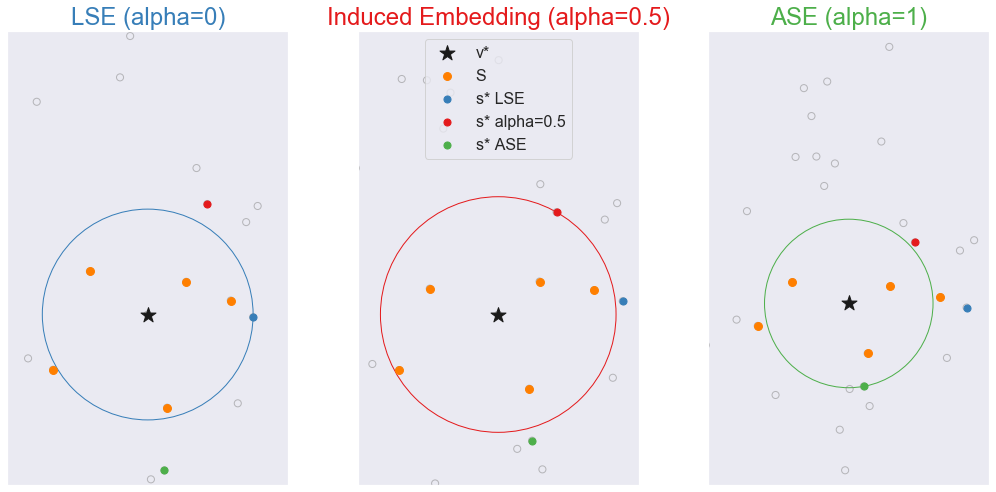

In [81]:
fig, ax = plt.subplots(1,3, figsize=(14,7))

alpha=0.5
s=50

i, j= 0, 0

# for i, emb in enumerate(embeds):
#     for j, p in enumerate(points):
#         ax[i].plot([emb[p, 0], emb[0, 0]], [emb[p, 1], emb[0,1]], ls='--', c='k', zorder=i+j+1)
        
ax[2].scatter(X_hat[:, 0], X_hat[:, 1], alpha=alpha, s=s, edgecolors='grey', marker='o', 
              facecolors='none', zorder=i+j+2)
ax[0].scatter(X_bre[:, 0], X_bre[:, 1], alpha=alpha, s=s, edgecolors='grey', marker='o', 
              facecolors='none', zorder=i+j+2)
ax[1].scatter(alpha_star_embed[:, 0], alpha_star_embed[:, 1], alpha=alpha, s=s, edgecolors='grey', marker='o', 
              facecolors='none', zorder=i+j+2)

ax[2].scatter(X_hat[0, 0], X_hat[0, 1], c='k', s=250, 
              marker='*', zorder=i+j+2)
ax[0].scatter(X_bre[0, 0], X_bre[0, 1], c='k', label='v*', s=250, 
              marker='*', zorder=i+j+2)
ax[1].scatter(alpha_star_embed[0, 0], alpha_star_embed[0, 1], c='k', s=250, 
              marker='*', zorder=i+j+2, label='v*')

ax[2].scatter(X_hat[S_indices[:-1], 0], X_hat[S_indices[:-1], 1], marker='.', c=o, s=5*s, zorder=i+j+2)
ax[0].scatter(X_bre[S_indices[:-1], 0], X_bre[S_indices[:-1], 1], label='S', marker='.', c=o, s=5*s, zorder=i+j+2)
ax[1].scatter(alpha_star_embed[S_indices[:-1], 0], alpha_star_embed[S_indices[:-1], 1], marker='.', c=o, s=5*s, zorder=i+j+2, label='S')

# ax[1].scatter(X_hat[S_indices[-1], 0], X_hat[S_indices[-1], 1], c='g')
# ax[2].scatter(X_bre[S_indices[-1], 0], X_bre[S_indices[-1], 1], c='g')

# ax[0].scatter(alpha_star_embed[S_indices[-1], 0], alpha_star_embed[S_indices[-1], 1], c='g', label='s*')

# ax[1].scatter(X_hat[S_indices_ASE[:-1], 0], X_hat[S_indices_ASE[:-1], 1], c='k', label='S ASE', s=s)
# ax[2].scatter(X_bre[S_indices_LSE[:-1], 0], X_bre[S_indices_LSE[:-1], 1], c='k', label='S LSE', s=s)

print(ase, lse)

ax[1].scatter(alpha_star_embed[lse, 0], alpha_star_embed[lse, 1], c=b, 
              marker='.', s=200, zorder=i+j+2, label='s* LSE')
ax[1].scatter(alpha_star_embed[S_indices[-1], 0], alpha_star_embed[S_indices[-1], 1], c=r, 
              marker='.', s=200, zorder=i+j+2, label='s* alpha=0.5')
ax[1].scatter(alpha_star_embed[ase, 0], alpha_star_embed[ase, 1], c=g, 
              marker='.', s=200, zorder=i+j+2, label='s* ASE')


ax[2].scatter(X_hat[lse, 0], X_hat[lse, 1], c=b, 
              marker='.', s=200, zorder=i+j+2)
ax[2].scatter(X_hat[S_indices[-1], 0], X_hat[S_indices[-1], 1], c=r, 
              marker='.', s=200, zorder=i+j+2)
ax[2].scatter(X_hat[ase, 0], X_hat[ase, 1], c=g, 
              marker='.', s=200, zorder=i+j+2)


ax[0].scatter(X_bre[lse, 0], X_bre[lse, 1], c=b, label='s* LSE', 
              marker='.', s=200, zorder=i+j+2)
ax[0].scatter(X_bre[S_indices[-1], 0], X_bre[S_indices[-1], 1], c=r,label='s* alpha=0.5', 
              marker='.', s=200, zorder=i+j+2)
ax[0].scatter(X_bre[ase, 0], X_bre[ase, 1], c=g, label='s* ASE', 
              marker='.', s=200, zorder=i+j+2)


title_fs=24
# ax[0].set_xlim(-0.01, 1.01)
# ax[0].set_ylim(-0.6, 0.6)
# ax[0].set_aspect('equal')
ax[1].axis('equal')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlim(alpha_star_embed[0,0] - 0.15, alpha_star_embed[0,0] + 0.15)
ax[1].set_ylim(alpha_star_embed[0,1] - 0.3, alpha_star_embed[0,1] + 0.5)
ax[1].set_title('Induced Embedding (alpha=0.5)', color=r, fontsize=title_fs)

# ax[1].set_xlim(0, 0.2)
# ax[1].set_ylim(-0.12, 0.12)
# ax[1].axisset_aspect('square')
ax[2].axis('equal')
# ax[1].legend(loc='upper left')
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_xlim(X_hat[0,0] - 0.3, X_hat[0,0] + 0.3)
ax[2].set_ylim(X_hat[0,1] - 0.3, X_hat[0,1] + 0.5)
ax[2].set_title('ASE (alpha=1)', color=g, fontsize=title_fs)

# ax[2].set_xlim(-0.41, 0.41)
# ax[2].set_ylim(-0.4, 0.4)
# ax[2].set_aspect('equal')
ax[0].axis('equal')
# ax[2].legend(loc='upper left')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlim(X_bre[0,0] - 0.15, X_bre[0,0] + 0.15)
ax[0].set_ylim(X_bre[0,1] - 0.3, X_bre[0,1] + 0.5)
ax[0].set_title('LSE (alpha=0)', color=b, fontsize=title_fs)
        
#         dist = np.linalg.norm(emb[p] - emb[0])
#         if j == 0:
#             ax[i].text(emb[p,0], emb[p,1]+0.001, f"{dist:0.3f}", fontsize=16)
#         elif j == 1:
#             ax[i].text(emb[p,0], emb[p,1]-0.013, f"{dist:0.3f}", fontsize=16)
#         else:
#             ax[i].text(emb[p,0], emb[p,1]+0.001, f"{dist:0.3f}", fontsize=16)

circle1 = plt.Circle((X_bre[0,0], X_bre[0,1]), 
                     radius= np.linalg.norm(X_bre[lse] - X_bre[0]),
                     fill=False,
                     color=b
                    )
ax[0].add_artist(circle1)


circle2 = plt.Circle((alpha_star_embed[0,0], alpha_star_embed[0,1]), 
                     radius= np.linalg.norm(alpha_star_embed[S_indices[-1]] - alpha_star_embed[0]),
                     fill=False,
                     color=r
                    )
ax[1].add_artist(circle2)


circle3 = plt.Circle((X_hat[0,0], X_hat[0,1]), 
                     radius= np.linalg.norm(X_hat[ase] - X_hat[0]),
                     fill=False,
                     color=g
                    )
ax[2].add_artist(circle3)



circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
circle3 = plt.Circle((1, 1), 0.2, color='g', clip_on=False)

# text_fs=22.5
# ax[0].text(X_bre[lse,0]-0.1, X_bre[lse,1]+0.03, f"{np.linalg.norm(X_bre[lse] - X_bre[0]):0.3f}", fontsize=text_fs)
# ax[0].text(X_bre[S_indices[-1],0]-0.15, X_bre[S_indices[-1],1]-0.12, f"{np.linalg.norm(X_bre[S_indices[-1]] - X_bre[0]):0.3f}", fontsize=text_fs)
# ax[0].text(X_bre[ase,0]-0.15, X_bre[ase,1]+0.05, f"{np.linalg.norm(X_bre[ase] - X_bre[0]):0.3f}", fontsize=text_fs)

# ax[1].text(alpha_star_embed[lse,0]-0.12, alpha_star_embed[lse,1]+0.04, 
#            f"{np.linalg.norm(alpha_star_embed[lse] - alpha_star_embed[0]):0.3f}", fontsize=text_fs)
# ax[1].text(alpha_star_embed[S_indices[-1],0]-0.12, alpha_star_embed[S_indices[-1],1]-0.12, 
#            f"{np.linalg.norm(alpha_star_embed[S_indices[-1]] - alpha_star_embed[0]):0.3f}", fontsize=text_fs)
# ax[1].text(alpha_star_embed[ase,0]-0.14, alpha_star_embed[ase,1]+0.04, 
#            f"{np.linalg.norm(alpha_star_embed[ase] - alpha_star_embed[0]):0.3f}", fontsize=text_fs)

# ax[2].text(X_hat[lse,0]-0.1, X_hat[lse,1]+0.03, f"{np.linalg.norm(X_hat[lse] - X_hat[0]):0.3f}", fontsize=text_fs)
# ax[2].text(X_hat[S_indices[-1],0]-0.1, X_hat[S_indices[-1],1]-0.09, f"{np.linalg.norm(X_hat[S_indices[-1]] - X_hat[0]):0.3f}", fontsize=text_fs)
# ax[2].text(X_hat[ase,0]-0.1, X_hat[ase,1]+0.035, f"{np.linalg.norm(X_hat[ase] - X_hat[0]):0.3f}", fontsize=text_fs)

ax[1].legend(loc='upper center', fontsize=16)


plt.tight_layout()
plt.savefig('figures/optimal-distance-9/your_truth_combined_circles.pdf')

In [7]:
embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [identity, identity]

J=len(embedding_functions)

mmrs_by_alpha_poc = np.zeros((len(alphas), 2, J+1))
alpha_hats_by_alpha_poc = np.zeros((len(alphas), 2))

n_inds = 5+1
s_stars =np.array([-1])
nmc=500

metric = 'rank'

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha_poc[i], mmrs_by_alpha_poc[i] = monte_carlo(2, P, embedding_functions,
                                                           covariance_functions,
                                                           alpha, n_inds, s_stars=s_stars, acorn=acorn, latent=True, 
                                                           metric=metric, poc=True)

lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50 30  4 42 35  7]
Using license file C:\Users\hhelm\gurobi.lic
Academic license - for non-commercial use only
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 30 42 35 28]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 30 35 28 42]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 30 35 28  8]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 30 35 28  8]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 30 35 28  8]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 30 35 28  8]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 35 30 28 10]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 35 30 10 28]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 35 30 10 28]
lse [50 30  4 42 35  7]
ase [50  4 35 10 30 32]
alpha [50  4 35 10 30 32]



In [511]:
alpha_hats_by_alpha_poc

array([[0.        , 0.        ],
       [0.05489772, 0.05489772],
       [0.05489772, 0.05489772],
       [0.05489772, 0.05489772],
       [0.05489772, 0.05489772],
       [0.05489772, 0.05489772],
       [0.05489772, 0.05489772],
       [0.05489772, 0.05489772],
       [0.9821744 , 0.9821744 ],
       [0.9821744 , 0.9821744 ],
       [1.        , 1.        ]])

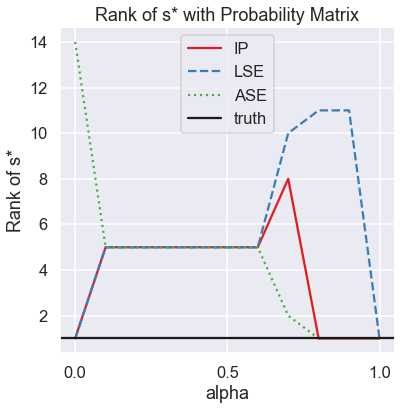

In [512]:
sns.set(context='talk')
labels = ['ASE', 'LSE', 'IP']
ls = ['-', '--', ':']
mean_mmrs = np.mean(mmrs_by_alpha_poc, axis=1)
std_err_mmrs = np.std(mmrs_by_alpha_poc, axis=1, ddof=1) / np.sqrt(nmc)

fig, ax = plt.subplots(1,1, figsize=(6,6))
c = sns.color_palette('Set1', n_colors=J+1)

for i in range(J+1):
#     ax.plot(np.arange(len(alphas)), mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.plot(alphas, mean_mmrs[:, -i-1], label = labels[-i-1], c=c[i], ls=ls[i])
    ax.fill_between(alphas, 
        mean_mmrs[:, -i-1] + 1.96*std_err_mmrs[:, -i-1], 
        mean_mmrs[:, -i-1] - 1.96*std_err_mmrs[:, -i-1], 
        where=mean_mmrs[:, -i-1] + 1.96*std_err_mmrs[:, -i-1] >= mean_mmrs[:, -i-1] - 1.96*std_err_mmrs[:, -i-1], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

truth = mean_rank(np.arange(n-1), [9]) #np.arange(np.math.ceil(n_inds(n)))
ax.set_xlabel('alpha')

if metric == 'rank':
    ax.set_title('Rank of s* with Probability Matrix')
    ax.set_ylabel('Rank of s*')
#     ax.set_ylim(0.5, 10.51)
    ax.axhline(y=1, label='truth', c='k')
#     ax.set_yticks([1, 5, 10])
else:
    ax.set_title('Absolute Rank Error with Probability Matrix')
    ax.set_ylabel('absolute rank error')
    ax.set_ylim(-0.1, 10.51)
    ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 0.5, 1])



ax.legend(loc='upper center')

# plt.savefig('figures/optimal-distance-7/%s_nmc%i_n%i_d%i_acorn%i_poc.png'%(metric, nmc, n, d, acorn))

In [377]:
alpha_hats_by_alpha_poc

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [345]:
nmc=500
n_inds=6
s_star=np.array([-1])

mmrs_by_alpha = np.zeros((len(alphas), nmc, J+1))
alpha_hats_by_alpha = np.zeros((len(alphas), nmc))

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha[i], mmrs_by_alpha[i] = monte_carlo(nmc, P, embedding_functions,
                                                           covariance_functions,
                                                           alpha, n_inds=n_inds, s_stars=s_stars, acorn=acorn, latent=True, poc=False)

pickle.dump(mmrs_by_alpha, open('figures/optimal-distance-7/%s_nmc%i_n%i_d%i_acorn%i.pkl'%(metric, nmc, n, d, acorn), 'wb'))

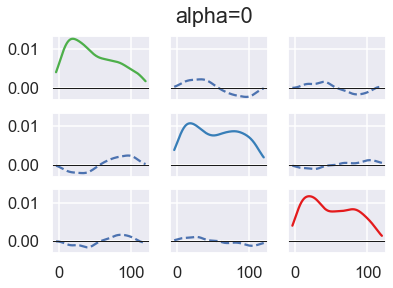

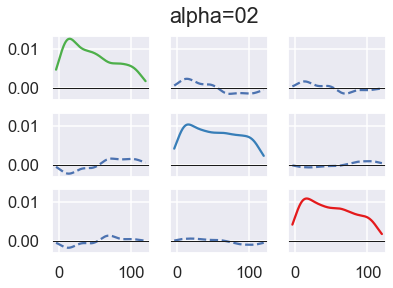

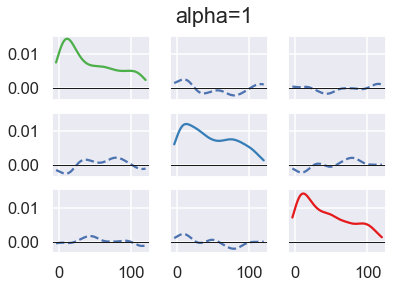

In [346]:
all_data0 = mmrs_by_alpha[0, :, :].T
filename='figures/optimal-distance-7/%s_kde_diffs_alpha0_nmc%i_n%i_d%i_acorn%i.png'%(metric, nmc, n, d, acorn)
plot_kde_differences(all_data0, suptitle='alpha=0', filename=filename, figsize=(12,8), h=5)

all_data02 = mmrs_by_alpha[2, :, :].T
filename='figures/optimal-distance-7/%s_kde_diffs_alpha02_nmc%i_n%i_d%i_acorn%i.png'%(metric, nmc, n, d, acorn)
plot_kde_differences(all_data02, suptitle='alpha=02', filename=filename, figsize=(12,8), h=5)

all_data1 = mmrs_by_alpha[-1, :, :].T
filename='figures/optimal-distance-7/%s_kde_diffs_alpha1_nmc%i_n%i_d%i_acorn%i.png'%(metric, nmc, n, d, acorn)
plot_kde_differences(all_data1, suptitle='alpha=1', filename=filename, figsize=(12,8), h=5)

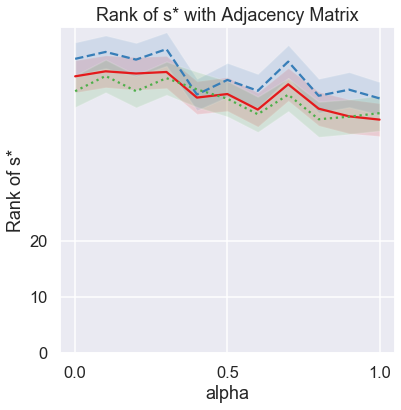

In [348]:
sns.set(context='talk')
labels = ['ASE', 'LSE', 'IP']
mean_mmrs = np.mean(mmrs_by_alpha, axis=1)
std_err_mmrs = np.std(mmrs_by_alpha, axis=1, ddof=1) / np.sqrt(nmc)

fig, ax = plt.subplots(1,1, figsize=(6,6))
c = sns.color_palette('Set1', n_colors=J+1)
for i in range(3):
#     ax.plot(np.arange(len(alphas)), mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.plot(alphas, mean_mmrs[:, -i-1], label = labels[-i-1], c=c[i], ls=ls[i])
    ax.fill_between(alphas, 
        mean_mmrs[:, -i-1] + 1.96*std_err_mmrs[:, -i-1], 
        mean_mmrs[:, -i-1] - 1.96*std_err_mmrs[:, -i-1], 
        where=mean_mmrs[:, -i-1] + 1.96*std_err_mmrs[:, -i-1] >= mean_mmrs[:, -i-1] - 1.96*std_err_mmrs[:, -i-1], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

truth = mean_rank(np.arange(n-1), [9]) #np.arange(np.math.ceil(n_inds(n)))
ax.set_xlabel('alpha')
ax.set_ylabel('Rank of s*')
ax.set_title('Rank of s* with Adjacency Matrix')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 10, 20])
# ax.set_ylim(9.89, 25.1)
# ax.legend(loc='upper left')

plt.savefig('figures/optimal-distance-7/%s_nmc%i_n%i_d%i_acorn%i_ninds%i.png'%(metric, nmc, n, d, n_inds, acorn))